# TM10007 Assignment
Authors: Noor Boegborn (4849051), Anne Meester (4299132), Bodessa Overbeek (4651987),  Marsha Kamsteeg (4680308)

In [2]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
!pip install tabulate

# Import modules

In [3]:
# Import modules
from sklearn.svm import SVC
from tabulate import tabulate
from adni.load_data import load_data
from sklearn.decomposition import PCA
from sklearn import neighbors, metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Description of data set
Import data from the ADNI dataset. 

Find empty values if present. 

Show the amount and percentage of samples from Alzheimer patients and healthy controls.

In [4]:
# Import Data
data = load_data()
data_pandas = pd.DataFrame(data)
print(f'Total number of samples: {len(data.index)}')
print(f'Total number of columns: {len(data.columns)}')
print(f'Total amount of features: {len(data.columns)-2}')

# Find empty / NaN entry in pandas dataframe
data_pandas = data_pandas.replace(' ', np.nan) 
empty_values = np.where(pd.isnull(data_pandas))
if ~empty_values[0] == []:
  print(f'Empty values can be found at index {empty_values}')
else:
  print('There are no empty values found.')
  pass

# Percentage AD and CN
number_AD = data_pandas['label'].value_counts()['AD']
number_CN = data_pandas['label'].value_counts()['CN']
print(f"Within the dataset {number_AD} ({number_AD/(number_AD+number_CN)*100:.2f}%) samples are from people with Alzheimer Disease")
print(f"The other {number_CN} ({number_CN/(number_AD+number_CN)*100:.2f}%) samples are from people without Alzheimer Disease") 


Total number of samples: 855
Total number of columns: 268
Total amount of features: 266
There are no empty values found.
Within the dataset 519 (60.70%) samples are from people with Alzheimer Disease
The other 336 (39.30%) samples are from people without Alzheimer Disease


# Preprocessing of the data

## Split data in a designset and testset

The split was stratified for the label [AD, CN]. The design set consists of 80% of the data and the test set consists of 20% of the data. 

In [5]:
# Divide data in label and feature set 
labels = data['label']
features = data.drop(columns=['label'])

# Divide data in trainingsset (80%) and testset (20%) stratified for the label
data_designset, data_testset, label_designset, label_testset = train_test_split(features, labels, test_size=.2, random_state=1, stratify=data['label'])

# Check the stratification 
percent_AD_train = (label_designset.value_counts()['AD'])/len(label_designset)*100
percent_CN_train = (label_designset.value_counts()['CN'])/len(label_designset)*100
percent_AD_test = (label_testset.value_counts()['AD'])/len(label_testset)*100
percent_CN_test = (label_testset.value_counts()['CN'])/len(label_testset)*100
print(f"{percent_AD_train:.2f}% of the train data are Alzheimer disease samples.")
print(f"{percent_CN_train:.2f}% of the train data are control samples.")
print(f"{percent_AD_test:.2f}% of the test data are Alzheimer disease samples.")
print(f"{percent_CN_test:.2f}% of the test data are control samples.")


60.67% of the train data are Alzheimer disease samples.
39.33% of the train data are control samples.
60.82% of the test data are Alzheimer disease samples.
39.18% of the test data are control samples.


## Evaluating Distribution
To investigate possible outliers, after univariate testing (written further on in the script), the 10 features with the highest scores were shown using boxplot and pairplot. There seem to be some outliers, nevertheless, the MinMax scaler was used.  

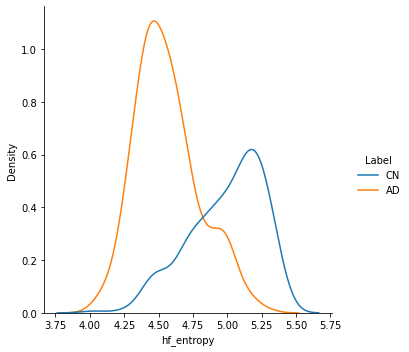

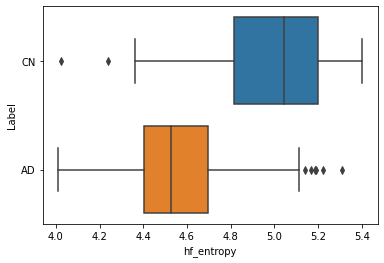

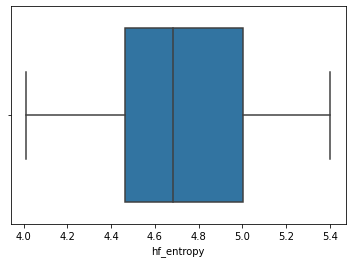

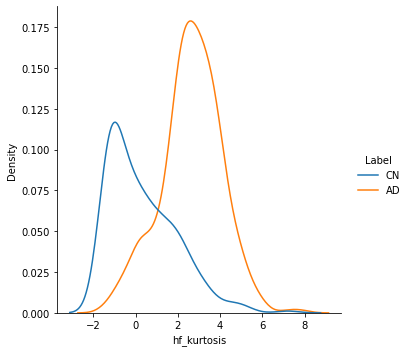

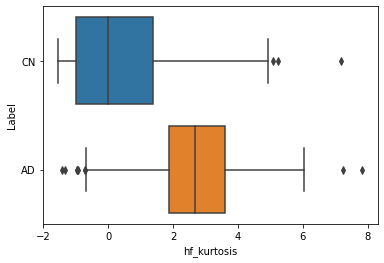

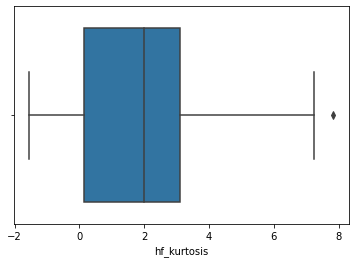

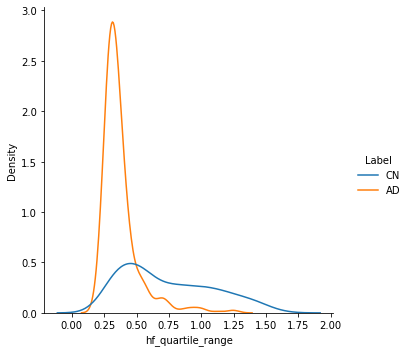

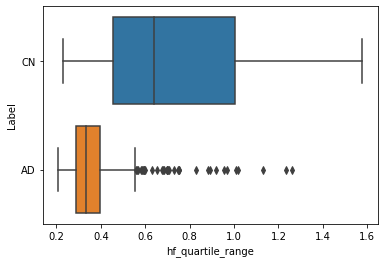

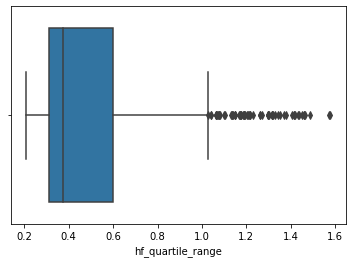

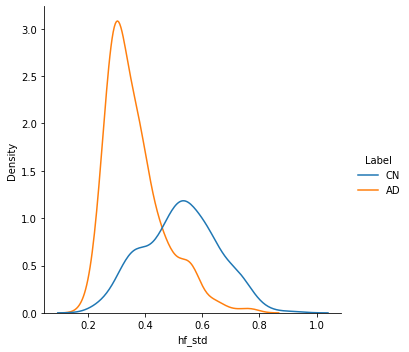

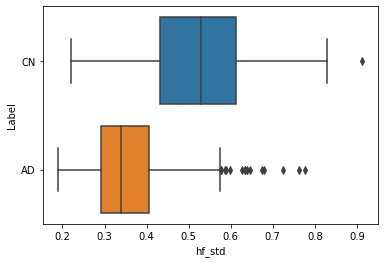

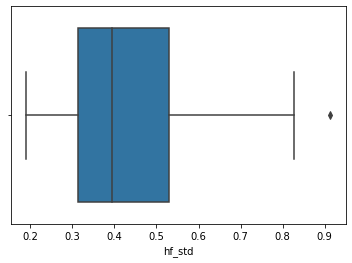

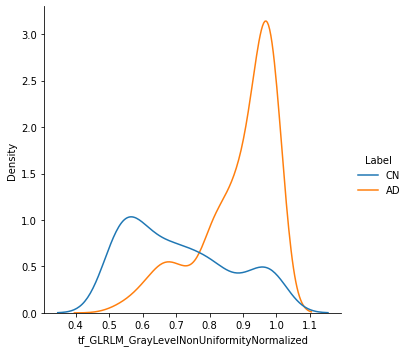

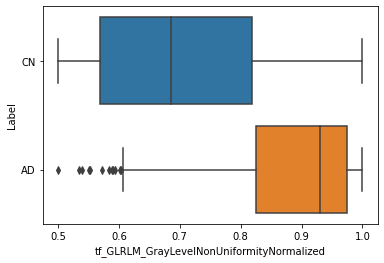

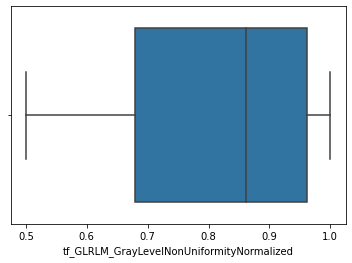

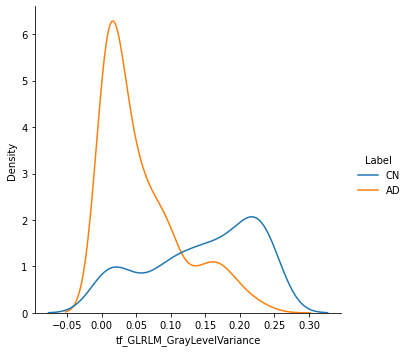

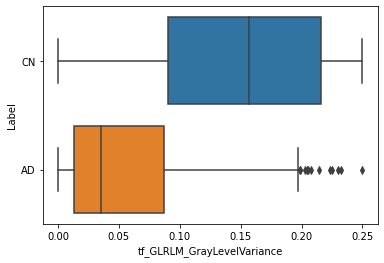

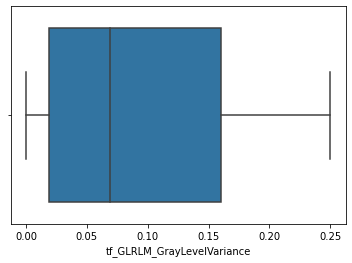

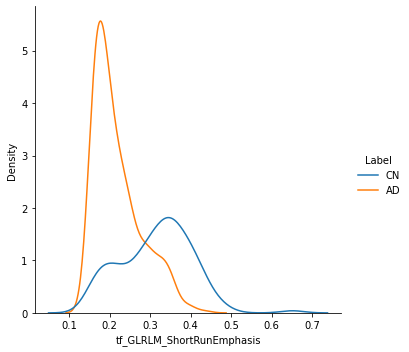

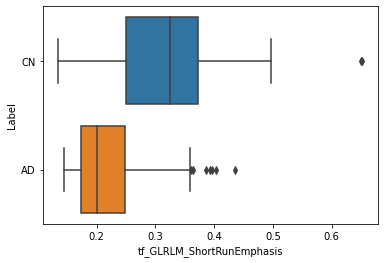

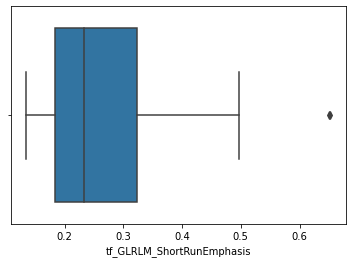

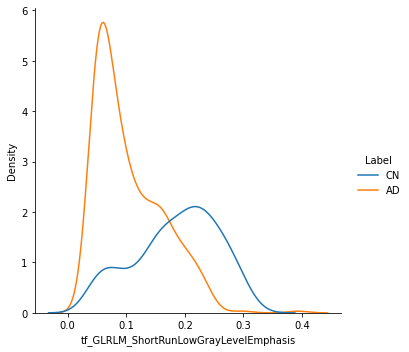

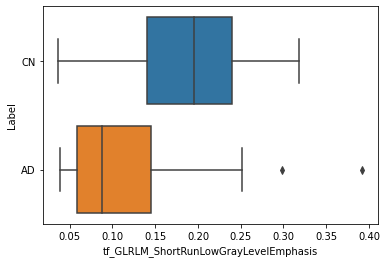

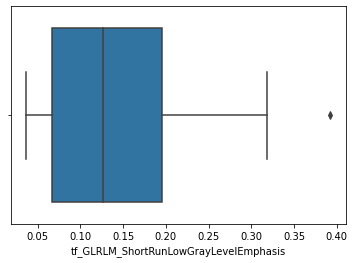

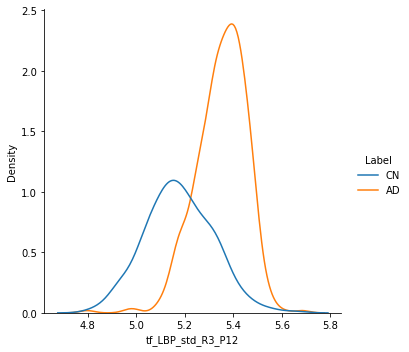

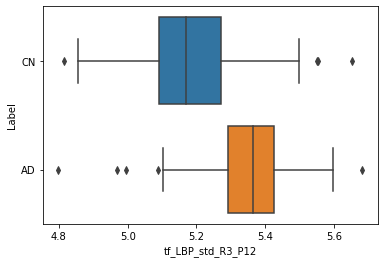

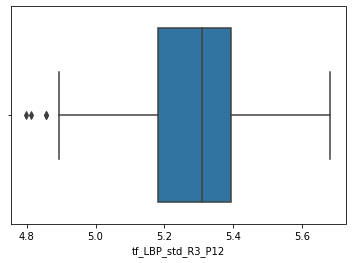

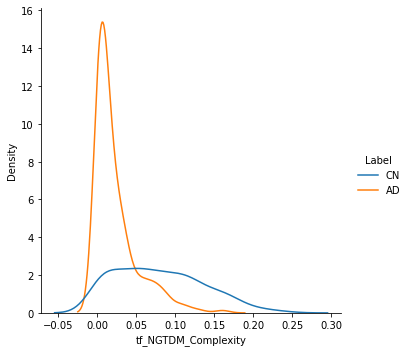

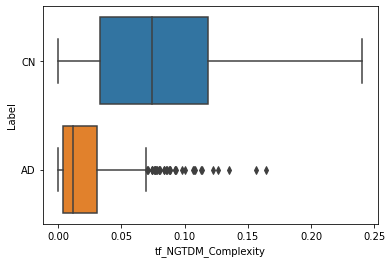

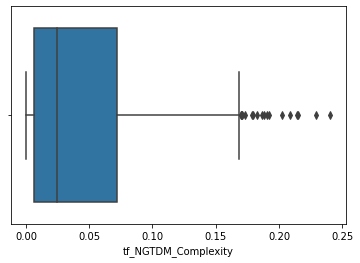

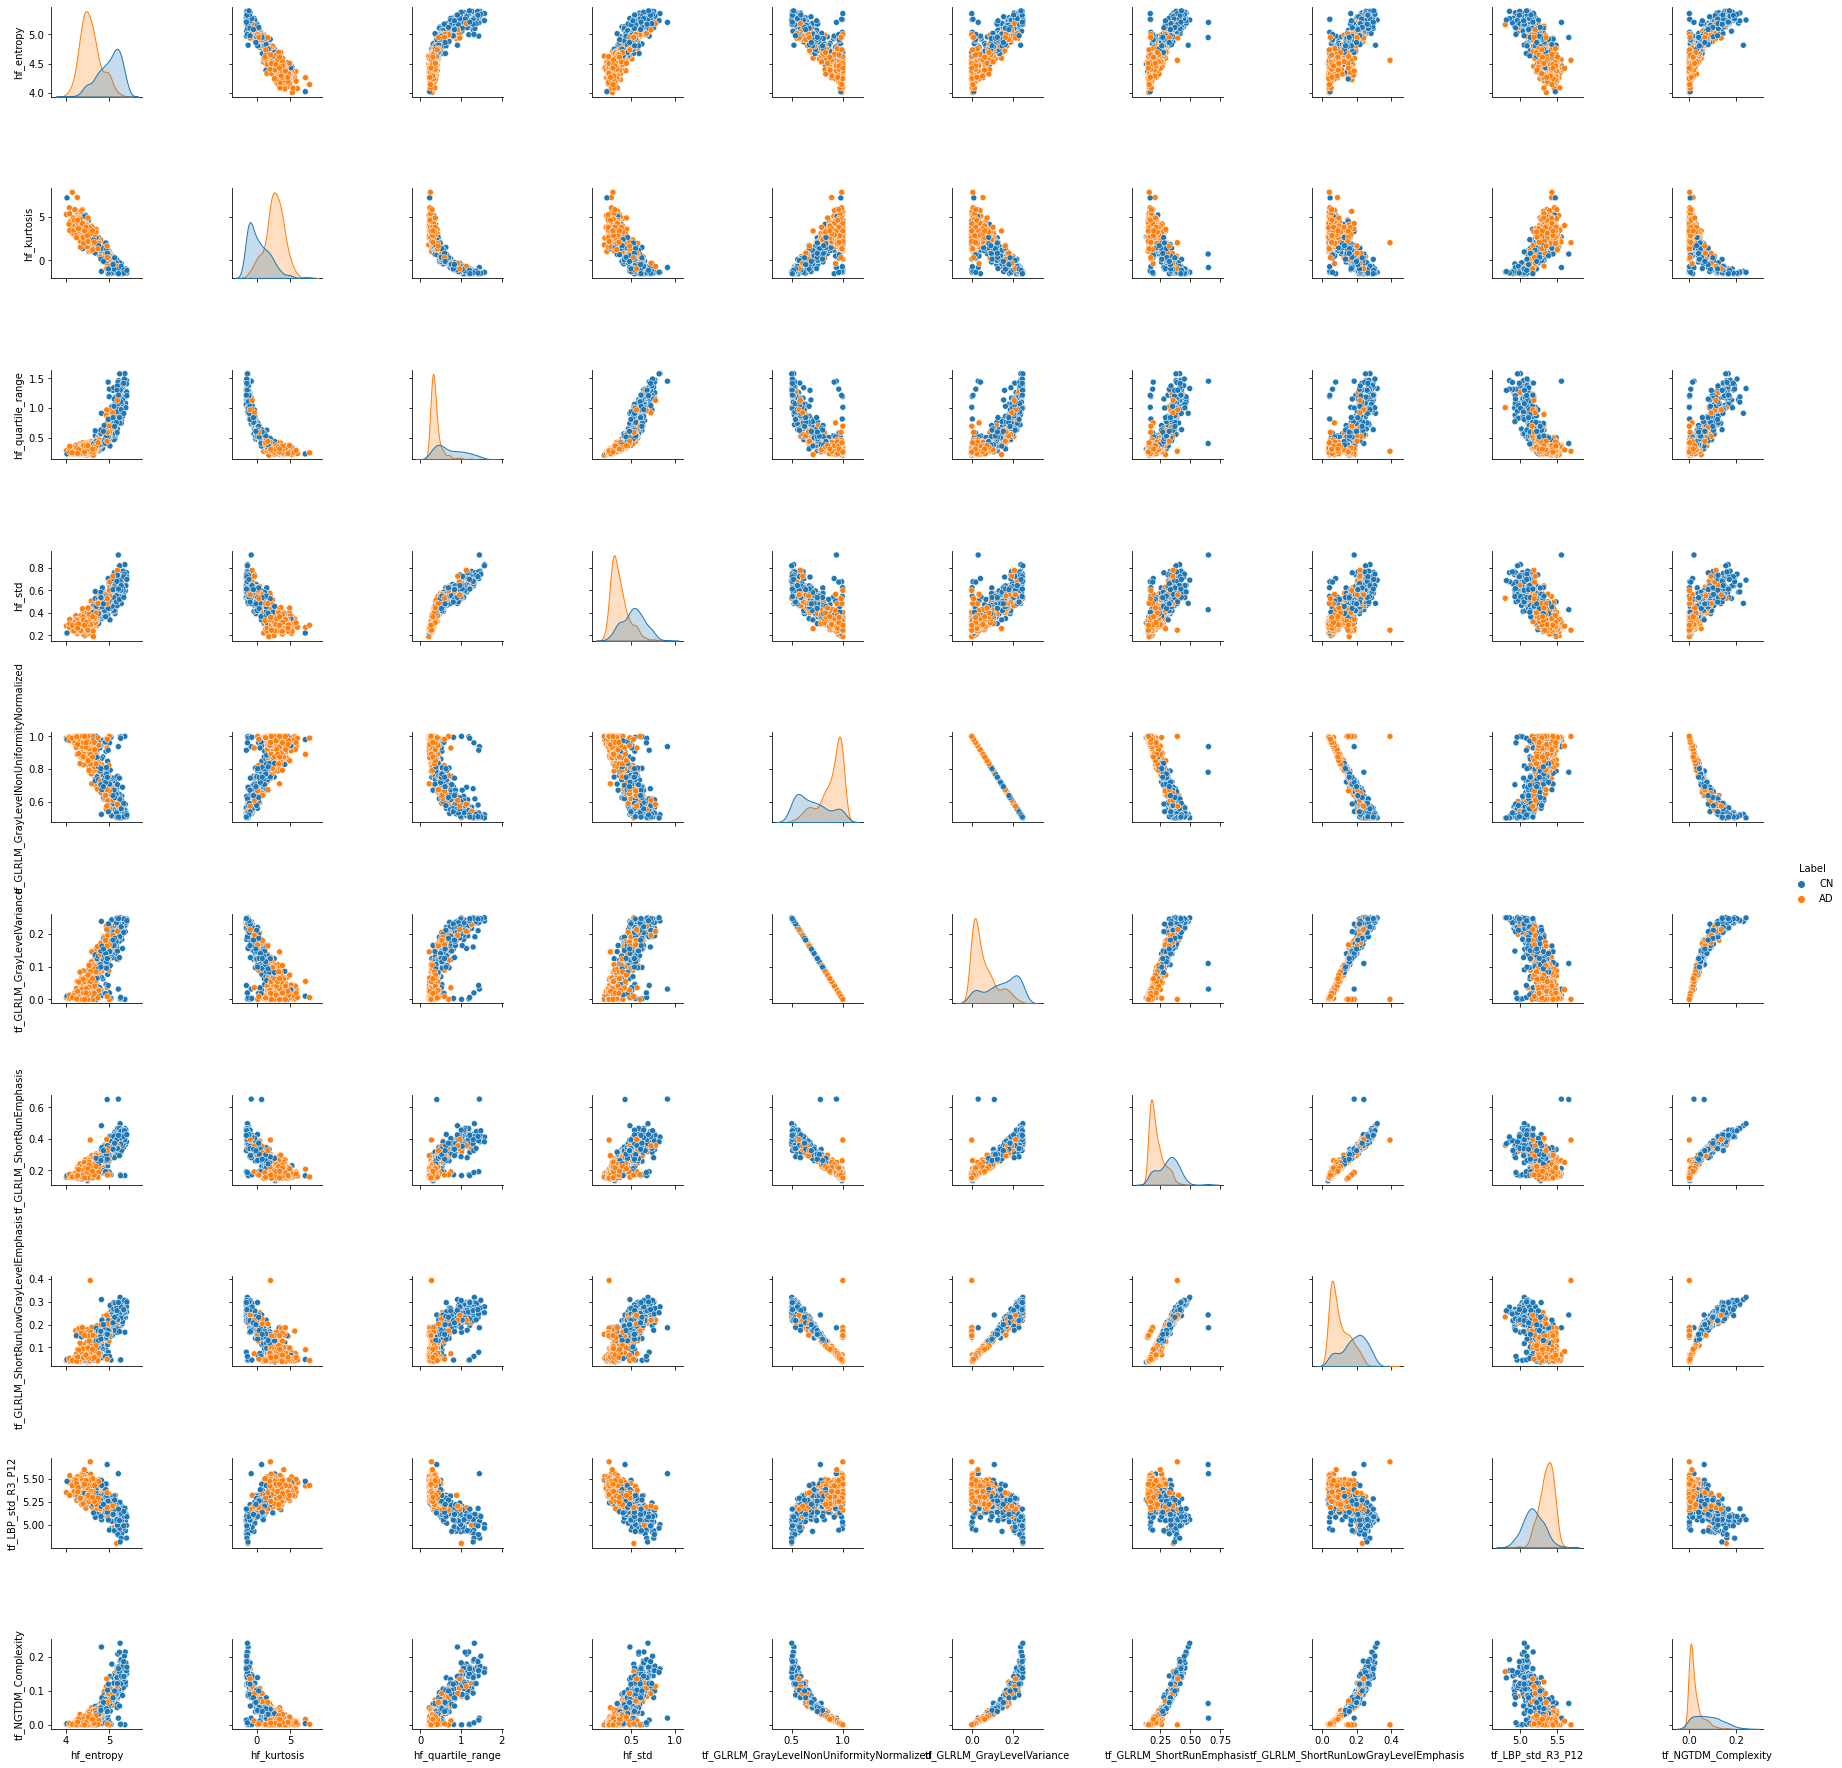

In [6]:
data_designset.describe()

features_to_evaluate = ['hf_entropy', 'hf_kurtosis', 'hf_quartile_range', 'hf_std',
 'tf_GLRLM_GrayLevelNonUniformityNormalized', 'tf_GLRLM_GrayLevelVariance', 
 'tf_GLRLM_ShortRunEmphasis', 'tf_GLRLM_ShortRunLowGrayLevelEmphasis', 'tf_LBP_std_R3_P12', 'tf_NGTDM_Complexity']
pairplot_data = data_designset[features_to_evaluate]
pairplot_data['Label'] = label_designset

for i in range(10):
  plt.show()
  sns.displot(pairplot_data, x=features_to_evaluate[i], hue="Label", kind="kde")

  plt.show()
  sns.boxplot( y=pairplot_data["Label"], x=pairplot_data.iloc[:,i]);

  plt.show()
  sns.boxplot( x=pairplot_data.iloc[:,i]);

plt.show()
sns.pairplot(pairplot_data, hue='Label')

## Feature dropping

Find columns where > 90% of the column has value zero. Remove the features if this is true. 

Besides, remove features if the whole column has one unique value. 

In [ ]:
# Find and drop features with low variance in the designset
data_designset = data_designset.drop(columns=data_designset.columns[data_designset.eq(0).mean()>0.9])
data_designset = data_designset[data_designset.columns[data_designset.nunique() > 1]]
data_designset_feature_names = data_designset.columns
print(f"After feature dropping, {data_designset.shape[1]} features of the initial {len(data.columns)-2} features remained.\n")
# Apply feature dropping to de testset
data_testset = data_testset[data_designset_feature_names]

After feature dropping, 258 features of the initial 266 features remained.



## Feature scaling
The MinMaxScaler, which scales all feature values in range [0,1], was used for feature scaling.

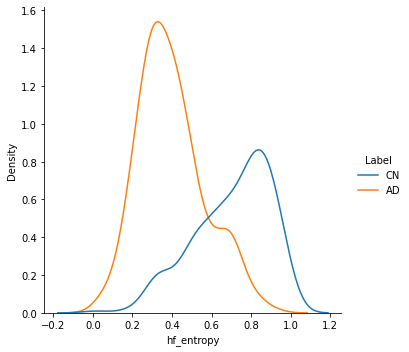

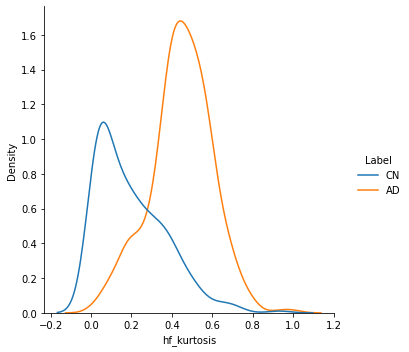

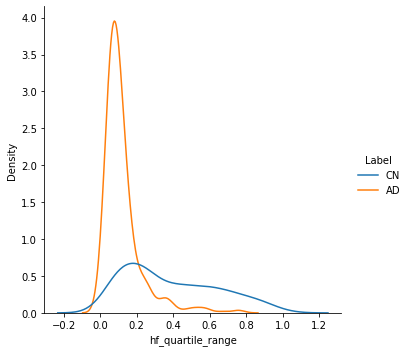

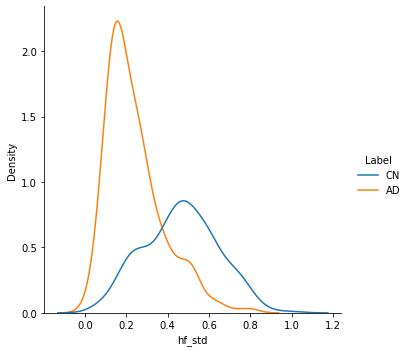

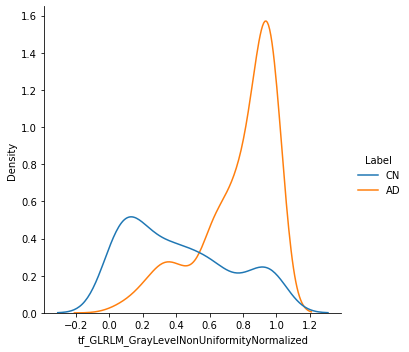

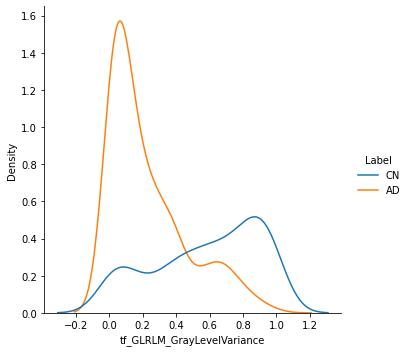

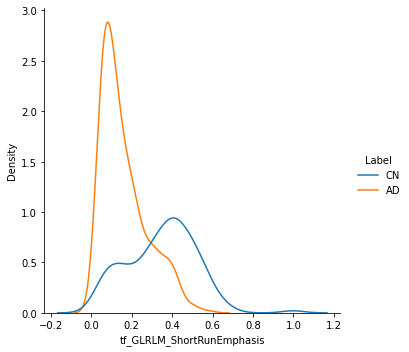

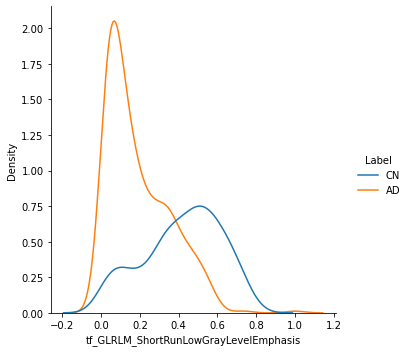

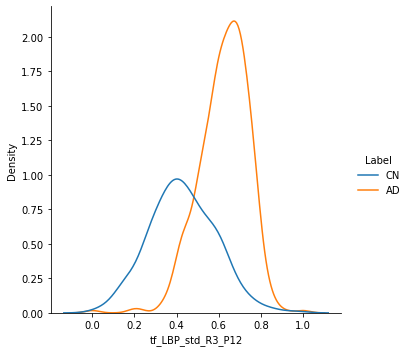

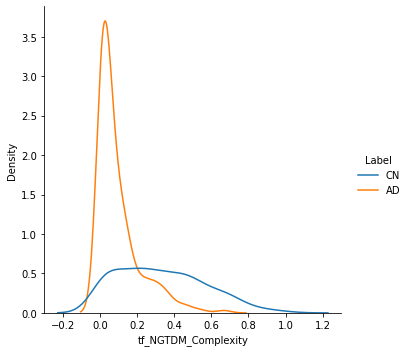

In [ ]:
# MinMax scaler - rescales data set such that all feature values are in range [0,1]
norm = MinMaxScaler().fit(data_designset)
# Apply feature scaling to the design set
data_designset_norm = norm.transform(data_designset)
data_designset_norm = pd.DataFrame(data_designset_norm)
data_designset_norm.columns = data_designset_feature_names
# Apply the feature scaling to the testset
data_testset_norm = norm.transform(data_testset)
data_testset_norm = pd.DataFrame(data_testset_norm)
data_testset_norm.columns = data_designset_feature_names
# Plot the results of the designset
pairplot_data = data_designset_norm[features_to_evaluate]
pairplot_data['Label'] = np.array(label_designset)
for i in range(10):
  plt.show()
  sns.displot(pairplot_data, x=features_to_evaluate[i], hue="Label", kind="kde")

# Training

## Cross validation
First a stratified shuffled split is used with 10 splits. 

Feature selection/transformation - best method to select features from this multi feature space. The options looked in to are:
1. Univariate feature selection
2. PCA
3. Univariate feature selection + PCA

Classifier - best classifier with the remaining features. Two classifiers are looked in to based on literature review.
1. K-NN
2. SVM 

In [ ]:
# Configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)

## Univariate feature selection

### Feature selection
Thresholds in range 0 to 1 in steps of 0.1 are used. The features are scored using one-way ANOVA. The thresholds are multiplied by the highest scoring feature. For every threshold the most common features over all 10 folds are saved. This will be used after the optimal threshold is determined.

In [ ]:
thresholds = np.linspace(0,1,11)
most_counted_selected_features = []

for threshold in thresholds:
  all_feature_selection_names = []
  all_lengths = []
  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    train_scores = []
    val_scores = []

    # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
    bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
    fit = bestfeatures.fit(x_train, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data_designset_norm.columns)

    # A threshold is set on 0.5 times the maximum scoring feature.
    feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
    feature_scores.columns = ['Specs','Score']  
    feature_scores = feature_scores.sort_values('Score')
    highest_feature_score = feature_scores['Score'].iloc[-1]
    threshold_feature_relative = threshold
    threshold_feature_score = threshold_feature_relative*highest_feature_score

    # Every feature scoring above the threshold will be selected. 
    feature_selection_names = []
    for i in range(0,len(feature_scores['Score'])):
      if feature_scores['Score'].iloc[i]>=threshold_feature_score:
        feature_selection_names.append(feature_scores['Specs'].iloc[i])
    all_lengths.append(len(feature_selection_names))
    all_feature_selection_names = np.append(all_feature_selection_names, feature_selection_names)

  mean_number_selection_features = np.array(all_lengths).mean().round().astype(int)
  unique_features = np.unique(all_feature_selection_names, return_counts=True)
  count_selected_features = pd.DataFrame(np.transpose(unique_features), columns=['Feature', 'Occurance'])
  count_selected_features['Occurance'] = count_selected_features['Occurance'].astype(str).astype(int)
  most_counted_selected_features.append(np.array(count_selected_features.nlargest(mean_number_selection_features, 'Occurance')['Feature']))


### KNN hyperparameter tuning
Tuning is done for the nearest neighbors and the threshold for unvariate feature selection.

Best classifier: k=31
Best classifier: k=49
Best classifier: k=33
Best classifier: k=47
Best classifier: k=29
Best classifier: k=49
Best classifier: k=19
Best classifier: k=37
Best classifier: k=29
Best classifier: k=35
The optimal N=34
Best classifier: k=41
Best classifier: k=41
Best classifier: k=47
Best classifier: k=27
Best classifier: k=47
Best classifier: k=43
Best classifier: k=47
Best classifier: k=33
Best classifier: k=49
Best classifier: k=27
The optimal N=42
Best classifier: k=47
Best classifier: k=47
Best classifier: k=47
Best classifier: k=39
Best classifier: k=35
Best classifier: k=49
Best classifier: k=39
Best classifier: k=35
Best classifier: k=49
Best classifier: k=25
The optimal N=43
Best classifier: k=25
Best classifier: k=27
Best classifier: k=15
Best classifier: k=17
Best classifier: k=9
Best classifier: k=21
Best classifier: k=27
Best classifier: k=19
Best classifier: k=19
Best classifier: k=25
The optimal N=20
Best classifier: k=33
Best classifier: k=41
Best clas

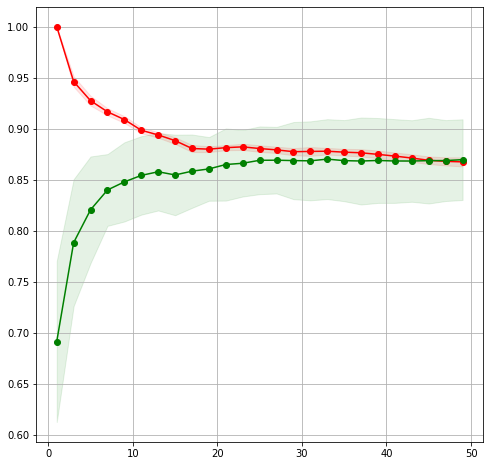

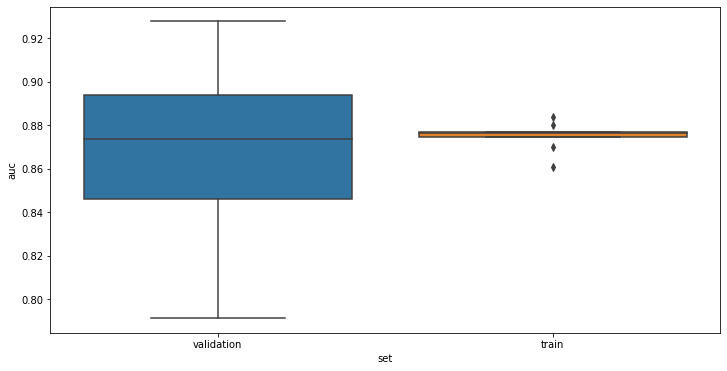

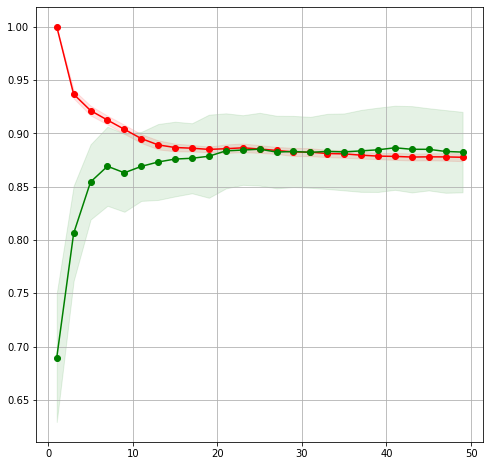

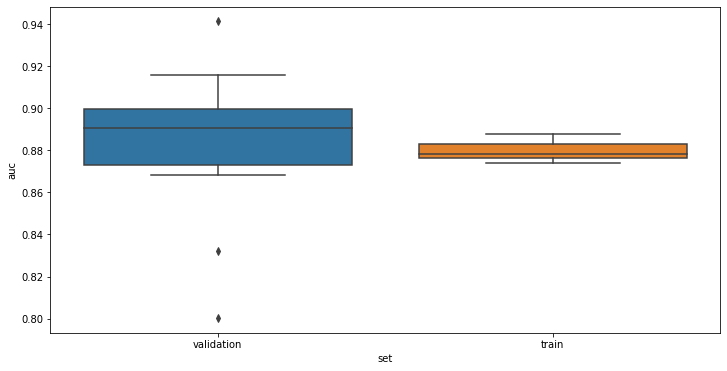

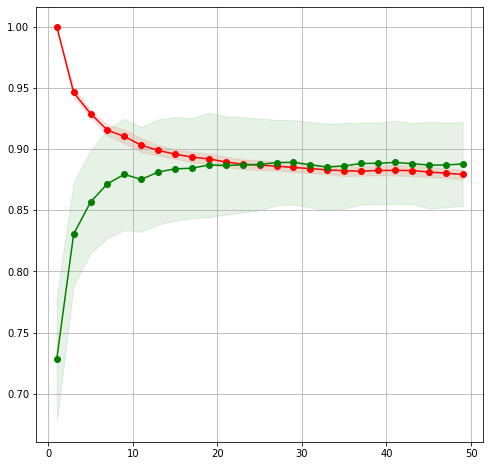

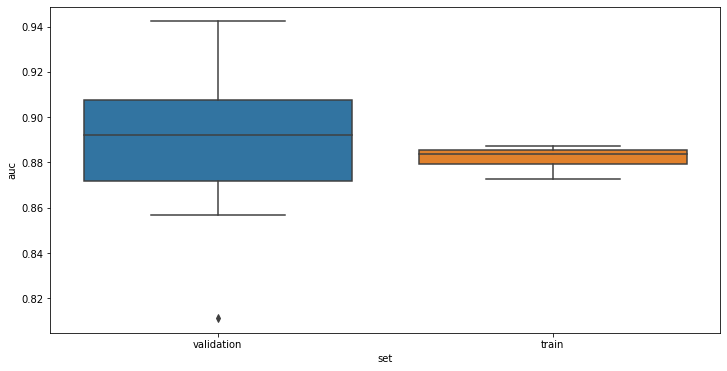

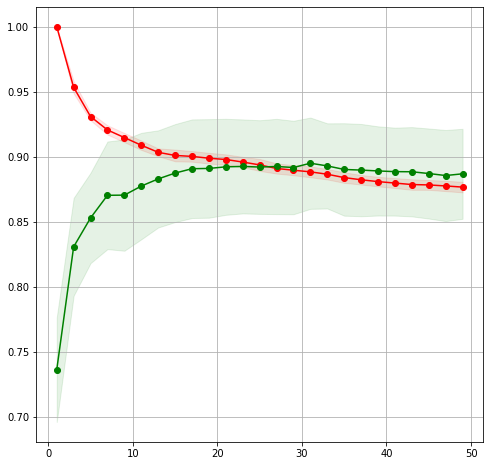

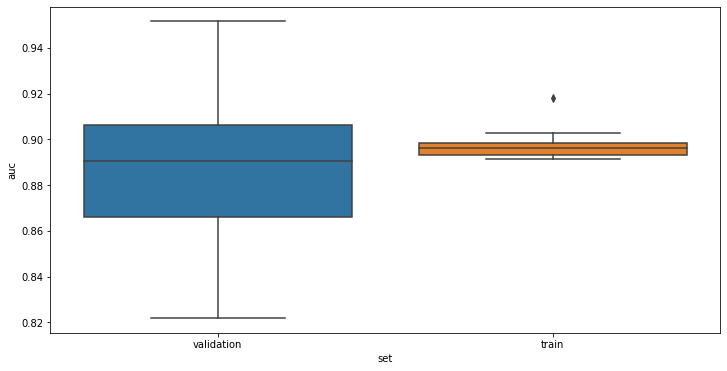

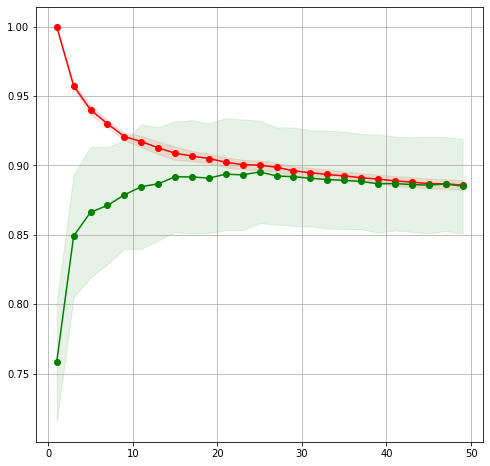

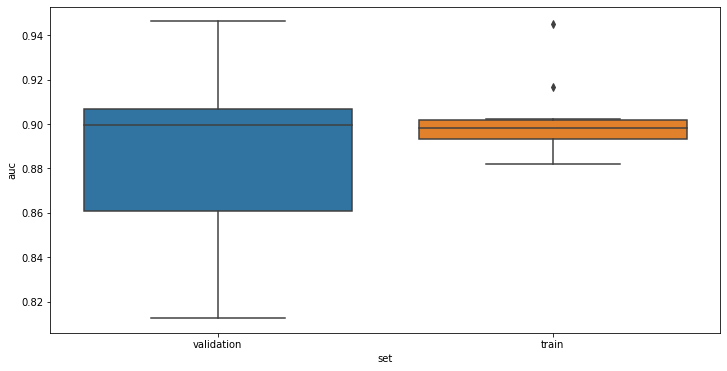

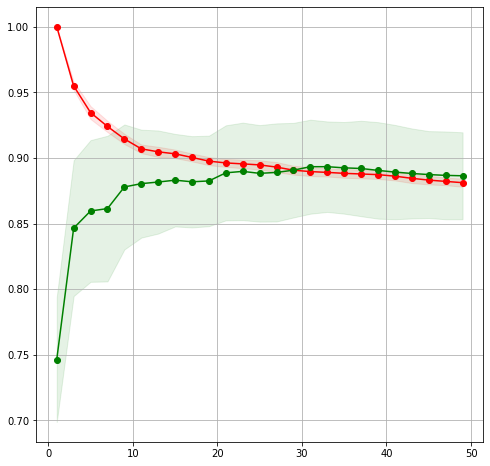

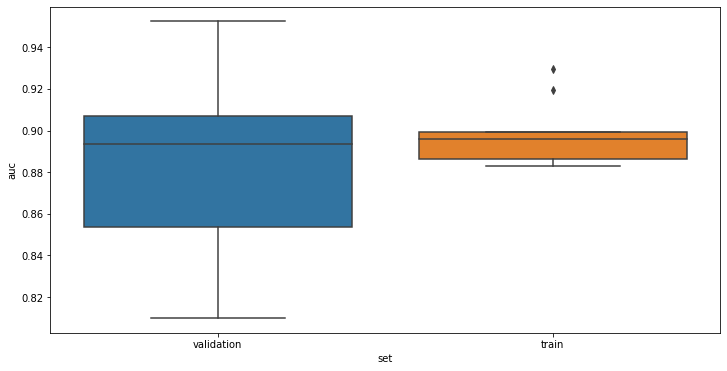

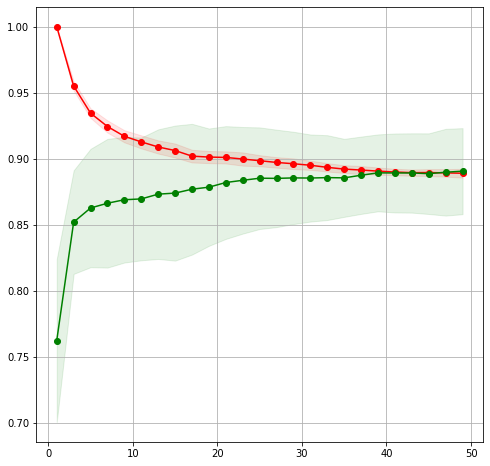

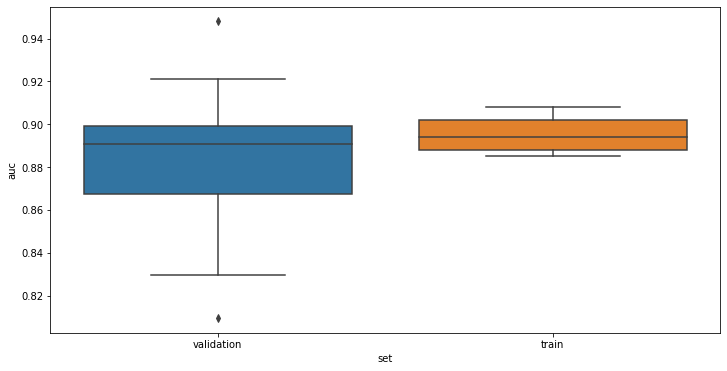

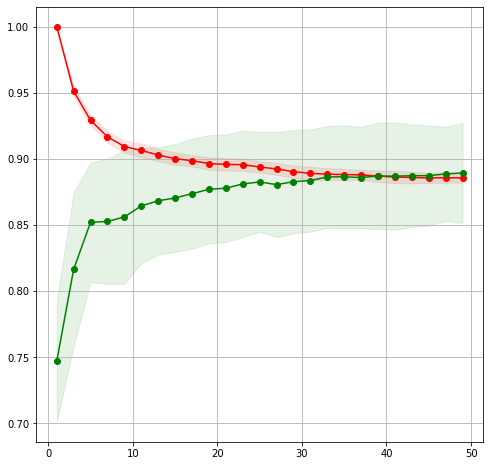

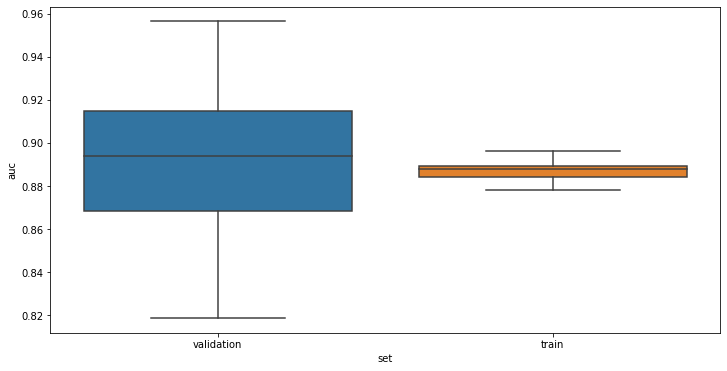

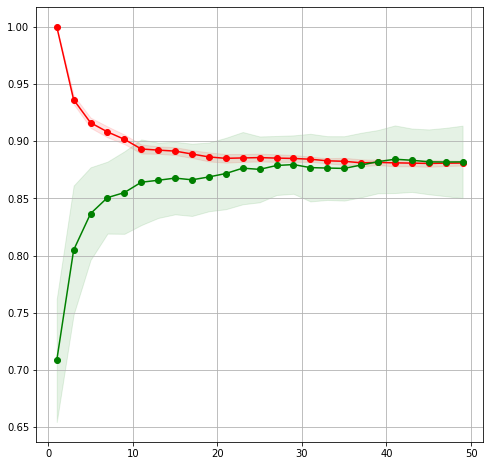

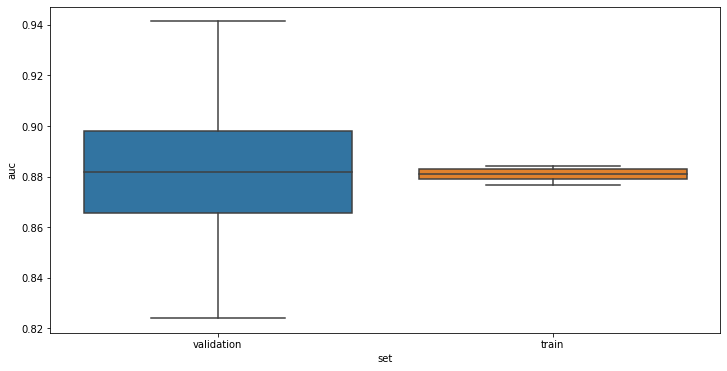

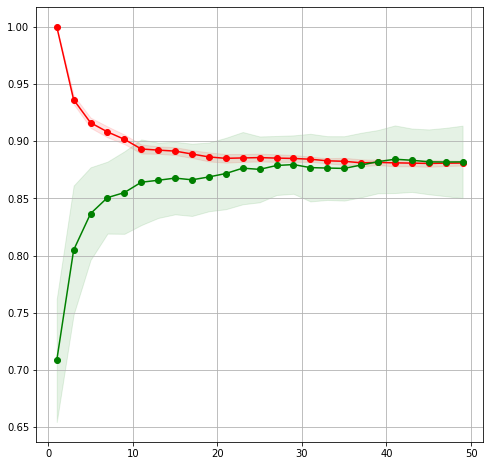

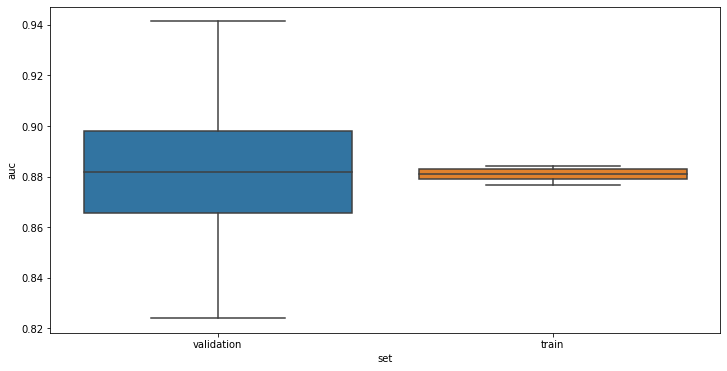

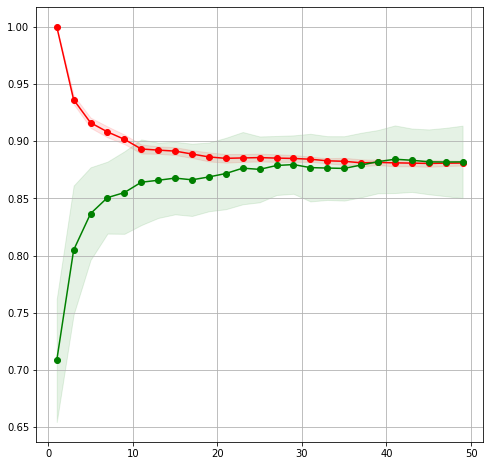

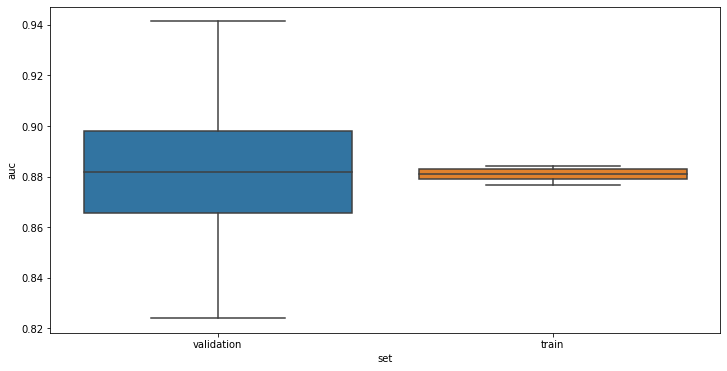

In [ ]:
k_list = list(range(1, 50, 2))
threshold_values = []
mean_auc_val = []
std_auc_val = []
optimal_k = []

thresholds = range(11)
for threshold in thresholds:
  all_train = []
  all_val = []
  results = []
  best_n_neighbors = []

  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    train_scores = []
    val_scores = []
    selected_data_univ_designset_norm = data_designset_norm[most_counted_selected_features[threshold]]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]

    
    # Aplly K-Nearest Neighbor classifier to features selected with univariate
    for k in k_list: 
      clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
      clf_knn.fit(selected_data_univ_trainset_norm, y_train)

      # Test the classifier on the selected features from the training data and plot 
      train_proba = clf_knn.predict_proba(selected_data_univ_trainset_norm)[:,1]
      val_proba = clf_knn.predict_proba(selected_data_univ_valset_norm)[:,1]

      score_train = metrics.roc_auc_score(y_train, train_proba)
      score_val = metrics.roc_auc_score(y_val, val_proba)

      train_scores.append(score_train)
      val_scores.append(score_val)

    all_train.append(train_scores)
    all_val.append(val_scores)

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 50, 2))}
    knn = neighbors.KNeighborsClassifier()
    grid_search = GridSearchCV(knn, parameters, cv=sss, scoring='roc_auc')
    grid_search.fit(selected_data_univ_trainset_norm, y_train)
    pd.DataFrame(grid_search.cv_results_)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(selected_data_univ_valset_norm)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_val, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
    # Test the classifier on the validation data
    probabilities_train = clf.predict_proba(selected_data_univ_trainset_norm)
    scores_train = probabilities_train[:, 1]
    
    # Get the auc
    auc_train = metrics.roc_auc_score(y_train, scores_train)
    results.append({
        'auc': auc_train,
        'k': clf.n_neighbors,
        'set': 'train'
    })
    
  # Calculate the mean and std
  all_train = np.array(all_train)
  all_val = np.array(all_val)

  train_scores_mean = all_train.mean(axis=0)
  val_scores_mean = all_val.mean(axis=0)

  train_scores_std = all_train.std(axis=0)
  val_scores_std = all_val.std(axis=0)

  # Plot the mean scores and the std as shading
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  ax.grid()
  ax.fill_between(k_list, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
  ax.fill_between(k_list, val_scores_mean - val_scores_std,
                      val_scores_mean + val_scores_std, alpha=0.1,
                      color="g")
  ax.plot(k_list, train_scores_mean, 'o-', color="r",
          label="Training score")
  ax.plot(k_list, val_scores_mean, 'o-', color="g",
          label="Validation score")
  
  # Create results dataframe and plot it
  plt.figure()
  results = pd.DataFrame(results)
  sns.boxplot(y='auc', x='set', data=results)

  auc_val = results[results['set'].str.contains('validation')]
  threshold_values.append(threshold*0.1)
  mean_auc_val.append(auc_val['auc'].mean())
  std_auc_val.append(auc_val['auc'].std())
  optimal_k.append(int(np.median(best_n_neighbors)))

  optimal_n = int(np.median(best_n_neighbors))
  print(f"The optimal N={optimal_n}")

auc_table = {'Threshold': threshold_values, 'Mean AUC': mean_auc_val, 'Standard deviation AUC': std_auc_val, 'Optimal k': optimal_k}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))


Based on the results from above, the KNN hyperparameters were set to: 
*   Threshold = 0.4
*   Number of Neighbors = 25

### SVM classifier choice
Several kernals were considered before hyperparameter tuning.

In [ ]:
# Kernels used:
kernels = ('Polynomial 2', 'Polynomial 3', 'Polynomial 4', 'Polynomial 5', 'Polynomial 6', 'Polynomial 7', 'Polynomial 8', 'Polynomial 9', 'Polynomial 10', 'RBF', 'Sigmoid','Linear')
def getClassifier(ktype): 
  if ktype == 0:
      # Polynomial kernal
      return SVC(kernel='poly', degree=2, gamma="auto", probability=True, random_state=0)
  elif ktype == 1:
      # Polynomial kernal
      return SVC(kernel='poly', degree=3, gamma="auto", probability=True, random_state=0)
  elif ktype == 2:
      # Polynomial kernal
      return SVC(kernel='poly', degree=4, gamma="auto", probability=True, random_state=0)
  elif ktype == 3:
      # Polynomial kernal
      return SVC(kernel='poly', degree=5, gamma="auto", probability=True, random_state=0)
  elif ktype == 4:
      # Polynomial kernal
      return SVC(kernel='poly', degree=6, gamma="auto", probability=True, random_state=0)
  elif ktype == 5:
      # Polynomial kernal
      return SVC(kernel='poly', degree=7, gamma="auto", probability=True, random_state=0)
  elif ktype == 6:
      # Polynomial kernal
      return SVC(kernel='poly', degree=8, gamma="auto", probability=True, random_state=0)
  elif ktype == 7:
      # Polynomial kernal
      return SVC(kernel='poly', degree=9, gamma="auto", probability=True, random_state=0)
  elif ktype == 8:
      # Polynomial kernal
      return SVC(kernel='poly', degree=10, gamma="auto", probability=True, random_state=0)
  elif ktype == 9:
      # Radial Basis Function kernal
      return SVC(kernel='rbf', gamma=0.01, C=1000, probability=True, random_state=0)
  elif ktype == 10:
      # Sigmoid kernal
      return SVC(kernel='sigmoid', gamma="auto", probability=True, random_state=0)
  elif ktype == 11:
      # Linear kernal
      return SVC(kernel='linear', gamma="auto", probability=True, random_state=0)

# Apply SVC and calculate the accuracy and AUC
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
all_train_mean = []
all_val_mean = []
all_train_std = []
all_val_std = []
all_mean_accuracies = []
all_mean_sensitivities = []
all_mean_specificities = []

ACCURACIES = []
SPECIFICITIES = []
SENSITIVITIES = []

for ker in range(12):
  train_scores = []
  val_scores = []

  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    
    selected_data_univ_designset_norm = data_designset_norm[most_counted_selected_features[5]]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]
    
    svclassifier = getClassifier(ker) 
    svclassifier.fit(selected_data_univ_trainset_norm, y_train)   # Train classifier 

    y_pred_train = svclassifier.predict(selected_data_univ_trainset_norm) # Apply classifier on trainset (Make prediction, label with class)
    y_pred_val = svclassifier.predict(selected_data_univ_valset_norm) # Apply classifier on validationset (Make prediction, label with class)
    y_pred_train_score = svclassifier.predict_proba(selected_data_univ_trainset_norm)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    y_pred_val_score = svclassifier.predict_proba(selected_data_univ_valset_norm)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    score_train = metrics.roc_auc_score(y_train, y_pred_train_score)
    score_val = metrics.roc_auc_score(y_val, y_pred_val_score)
    train_scores.append(score_train)
    val_scores.append(score_val)

    classification_report_val = classification_report(y_val,y_pred_val, output_dict=True)
    accuracy = classification_report_val['accuracy']
    sensitivity = classification_report_val['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
    specificity = classification_report_val['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

    ACCURACIES.append(accuracy)
    SENSITIVITIES.append(sensitivity)
    SPECIFICITIES.append(specificity)
    
  mean_accuracies = np.array(ACCURACIES).mean()
  all_mean_accuracies.append(mean_accuracies)
  mean_sensitivities = np.array(SENSITIVITIES).mean()
  all_mean_sensitivities.append(mean_sensitivities)
  mean_specificities = np.array(SPECIFICITIES).mean()
  all_mean_specificities.append(mean_specificities)

  train_scores_std = np.array(train_scores).std()
  val_scores_std = np.array(val_scores).std()

  train_scores_mean = np.array(train_scores).mean()
  val_scores_mean = np.array(val_scores).mean()

  all_train_mean.append(train_scores_mean)
  all_train_std.append(train_scores_std)
  all_val_mean.append(val_scores_mean)
  all_val_std.append(val_scores_std)
 
auc_table = {'Classifier': kernels, 'Mean AUC': all_val_mean, 'Standard deviation AUC': all_val_std, 'Mean Accuracy': all_mean_accuracies, 'Mean Sensitivity': all_mean_sensitivities, 'Mean Specificity': all_mean_specificities}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid')) 


╒═══════════════╤════════════╤══════════════════════════╤═════════════════╤════════════════════╤════════════════════╕
│ Classifier    │   Mean AUC │   Standard deviation AUC │   Mean Accuracy │   Mean Sensitivity │   Mean Specificity │
╞═══════════════╪════════════╪══════════════════════════╪═════════════════╪════════════════════╪════════════════════╡
│ Polynomial 2  │   0.86843  │                0.0353434 │        0.785507 │           0.904762 │           0.6      │
├───────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ Polynomial 3  │   0.857937 │                0.0383359 │        0.783333 │           0.935714 │           0.546296 │
├───────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ Polynomial 4  │   0.852822 │                0.040745  │        0.754106 │           0.955556 │           0.440741 │
├───────────────┼────────────┼──────────────────────────

### SVM hyperparameter tuning
Since all the kernels have more or less the same performance, all the kernels will be considered. The polynomial kernel with a degree of 3 has the best score. This will be used for further hyperparameter tuning. Tuning is done for C, gamma, kernel and the threshold for unvariate feature selection.

In [ ]:
ACCURACIES_poly = []
ACCURACIES_lin = []
ACCURACIES_rbf = [] 
ACCURACIES_sig = [] 
SENSITIVITIES_poly = []
SENSITIVITIES_lin = []
SENSITIVITIES_rbf = [] 
SENSITIVITIES_sig = [] 
SPECIFICITIES_poly = []
SPECIFICITIES_lin = []
SPECIFICITIES_rbf = [] 
SPECIFICITIES_sig = [] 
ROC_AUC_poly = []
ROC_AUC_lin = [] 
ROC_AUC_rbf = []
ROC_AUC_sig = []

thresholds = range(2, 11)

for threshold in thresholds:
  print(f'New loop with threshold: {threshold}')
  selected_data_univ_designset_norm = data_designset_norm[most_counted_selected_features[threshold]]

  # defining parameter range Poly
  param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['poly'], 'degree': [3]}
  grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_univ_designset_norm, label_designset)
  print('Poly',grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_univ_designset_norm)
  grid_predictions_score = grid_search_svm.predict_proba(selected_data_univ_designset_norm)[:,1]
  classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
  accuracy = classification_report_design['accuracy']
  sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
  specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

  ACCURACIES_poly.append(accuracy)
  SENSITIVITIES_poly.append(sensitivity)
  SPECIFICITIES_poly.append(specificity)
  auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
  ROC_AUC_poly.append(auc_score)

  # defining parameter range Linear
  param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear']}
  grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_univ_designset_norm, label_designset)
  print('Linear',grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_univ_designset_norm)
  grid_predictions_score = grid_search_svm.predict_proba(selected_data_univ_designset_norm)[:,1]
  classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
  accuracy = classification_report_design['accuracy']
  sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
  specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

  ACCURACIES_lin.append(accuracy)
  SENSITIVITIES_lin.append(sensitivity)
  SPECIFICITIES_lin.append(specificity)
  auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
  ROC_AUC_lin.append(auc_score)

  # defining parameter range RBF
  param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
  grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_univ_designset_norm, label_designset)
  print('RBF',grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_univ_designset_norm)
  grid_predictions_score = grid_search_svm.predict_proba(selected_data_univ_designset_norm)[:,1]
  classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
  accuracy = classification_report_design['accuracy']
  sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
  specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

  ACCURACIES_rbf.append(accuracy)
  SENSITIVITIES_rbf.append(sensitivity)
  SPECIFICITIES_rbf.append(specificity)
  auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
  ROC_AUC_rbf.append(auc_score)

  # defining parameter range Sigmoid
  param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['sigmoid']}
  grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_univ_designset_norm, label_designset)
  print('Sigmoid',grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_univ_designset_norm)
  grid_predictions_score = grid_search_svm.predict_proba(selected_data_univ_designset_norm)[:,1]
  classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
  accuracy = classification_report_design['accuracy']
  sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
  specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

  ACCURACIES_sig.append(accuracy)
  SENSITIVITIES_sig.append(sensitivity)
  SPECIFICITIES_sig.append(specificity)
  auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
  ROC_AUC_sig.append(auc_score)

print(f'Accuracies: {ACCURACIES_poly} \n {ACCURACIES_lin} \n {ACCURACIES_rbf} \n {ACCURACIES_sig}')
print(f'ROC AUC scores: {ROC_AUC_poly} \n {ROC_AUC_lin} \n {ROC_AUC_rbf} \n {ROC_AUC_sig}')

classifier_names = ['Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid']
n_component_names = ['0.2', '', '', '','0.3', '', '', '', '0.4', '', '', '', '0.5', '', '', '', '0.6', '', '', '', '0.7', '', '', '', '0.8', '', '', '', '0.9', '', '', '', '1.0', '', '', '']
mean_auc_scores = [ROC_AUC_poly[0], ROC_AUC_lin[0], ROC_AUC_rbf[0], ROC_AUC_sig[0],ROC_AUC_poly[1], ROC_AUC_lin[1], ROC_AUC_rbf[1], ROC_AUC_sig[1],ROC_AUC_poly[2], ROC_AUC_lin[2], ROC_AUC_rbf[2], ROC_AUC_sig[2], ROC_AUC_poly[3], ROC_AUC_lin[3], ROC_AUC_rbf[3], ROC_AUC_sig[3],ROC_AUC_poly[4], ROC_AUC_lin[4], ROC_AUC_rbf[4], ROC_AUC_sig[4],ROC_AUC_poly[5], ROC_AUC_lin[5], ROC_AUC_rbf[5], ROC_AUC_sig[5],ROC_AUC_poly[6], ROC_AUC_lin[6], ROC_AUC_rbf[6], ROC_AUC_sig[6] ,ROC_AUC_poly[7], ROC_AUC_lin[7], ROC_AUC_rbf[7], ROC_AUC_sig[7] ,ROC_AUC_poly[8], ROC_AUC_lin[8], ROC_AUC_rbf[8], ROC_AUC_sig[8]]
accuracies_combined = [ACCURACIES_poly[0], ACCURACIES_lin[0], ACCURACIES_rbf[0], ACCURACIES_sig[0], ACCURACIES_poly[1], ACCURACIES_lin[1], ACCURACIES_rbf[1], ACCURACIES_sig[1], ACCURACIES_poly[2], ACCURACIES_lin[2], ACCURACIES_rbf[2], ACCURACIES_sig[2], ACCURACIES_poly[3], ACCURACIES_lin[3], ACCURACIES_rbf[3], ACCURACIES_sig[3], ACCURACIES_poly[4], ACCURACIES_lin[4], ACCURACIES_rbf[4], ACCURACIES_sig[4], ACCURACIES_poly[5], ACCURACIES_lin[5], ACCURACIES_rbf[5], ACCURACIES_sig[5], ACCURACIES_poly[6], ACCURACIES_lin[6], ACCURACIES_rbf[6], ACCURACIES_sig[6], ACCURACIES_poly[7], ACCURACIES_lin[7], ACCURACIES_rbf[7], ACCURACIES_sig[7], ACCURACIES_poly[8], ACCURACIES_lin[8], ACCURACIES_rbf[8], ACCURACIES_sig[8]] 
sensitivities_combined = [SENSITIVITIES_poly[0], SENSITIVITIES_lin[0], SENSITIVITIES_rbf[0], SENSITIVITIES_sig[0], SENSITIVITIES_poly[1], SENSITIVITIES_lin[1], SENSITIVITIES_rbf[1], SENSITIVITIES_sig[1], SENSITIVITIES_poly[2], SENSITIVITIES_lin[2], SENSITIVITIES_rbf[2], SENSITIVITIES_sig[2], SENSITIVITIES_poly[3], SENSITIVITIES_lin[3], SENSITIVITIES_rbf[3], SENSITIVITIES_sig[3], SENSITIVITIES_poly[4], SENSITIVITIES_lin[4], SENSITIVITIES_rbf[4], SENSITIVITIES_sig[4], SENSITIVITIES_poly[5], SENSITIVITIES_lin[5], SENSITIVITIES_rbf[5], SENSITIVITIES_sig[5], SENSITIVITIES_poly[6], SENSITIVITIES_lin[6], SENSITIVITIES_rbf[6], SENSITIVITIES_sig[6], SENSITIVITIES_poly[7], SENSITIVITIES_lin[7], SENSITIVITIES_rbf[7], SENSITIVITIES_sig[7], SENSITIVITIES_poly[8], SENSITIVITIES_lin[8], SENSITIVITIES_rbf[8], SENSITIVITIES_sig[8]] 
specificities_combined = [SPECIFICITIES_poly[0], SPECIFICITIES_lin[0], SPECIFICITIES_rbf[0], SPECIFICITIES_sig[0], SPECIFICITIES_poly[1], SPECIFICITIES_lin[1], SPECIFICITIES_rbf[1], SPECIFICITIES_sig[1], SPECIFICITIES_poly[2], SPECIFICITIES_lin[2], SPECIFICITIES_rbf[2], SENSITIVITIES_sig[2], SPECIFICITIES_poly[3], SPECIFICITIES_lin[3], SPECIFICITIES_rbf[3], SPECIFICITIES_sig[3], SPECIFICITIES_poly[4], SPECIFICITIES_lin[4], SPECIFICITIES_rbf[4], SPECIFICITIES_sig[4], SPECIFICITIES_poly[5], SPECIFICITIES_lin[5], SPECIFICITIES_rbf[5], SPECIFICITIES_sig[5], SPECIFICITIES_poly[6], SPECIFICITIES_lin[6], SPECIFICITIES_rbf[6], SPECIFICITIES_sig[6], SPECIFICITIES_poly[7], SPECIFICITIES_lin[7], SPECIFICITIES_rbf[7], SPECIFICITIES_sig[7], SPECIFICITIES_poly[8], SPECIFICITIES_lin[8], SPECIFICITIES_rbf[8], SPECIFICITIES_sig[8]] 
auc_table = {'Relative Thresholds': n_component_names, 'Classifier': classifier_names, 'Mean AUC score': mean_auc_scores, 'Accuracy': accuracies_combined, 'Sensitivity': sensitivities_combined, 'Specificity': specificities_combined}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))


New loop with threshold: 2
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Poly SVC(C=10, gamma=0.1, kernel='poly', probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Linear SVC(C=1000, gamma=1, kernel='linear', probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
RBF SVC(C=1000, gamma=0.01, probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Sigmoid SVC(C=1000, gamma=0.01, kernel='sigmoid', probability=True)
New loop with threshold: 3
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Poly SVC(C=0.1, gamma=1, kernel='poly', probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Linear SVC(C=10, gamma=1, kernel='linear', probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
RBF SVC(C=100, gamma=0.1, probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Sigmoid SVC(C=1000, gamma=0.01, kernel='sig

Based on the table above the following hyperparameters are used for the classification: 
*   Polynomal third degree: Threshold = 0.2, C=10, gamma=0.1
*   Linear: Threshold = 0.2, C=1000, gamma=1
*   RBF: Threshold = 0.2, C=1000, gamma=0.01
*   Sigmoid: Threshold = 0.2, C=1000, gamma=0.01

### Optimized classifiers

In [ ]:
# Which kernels do we use:
kernels = ('SVM Polynomial 3', 'SVM Linear', 'SVM RBF', 'SVM Sigmoid', 'K-Nearest Neighbor')#A function which returns the corresponding SVC model
def getClassifier(ktype): 
  if ktype == 0:
      # Support Vector Machine Polynomial kernel
      return SVC(kernel='poly', degree=3, C=10, gamma=0.1, probability=True, random_state=0)
  elif ktype == 1:
      # Support Vector Machine Linear kernel
      return SVC(kernel='linear', C=1000, gamma=1, probability=True, random_state=0)
  elif ktype == 2:
      # Support Vector Machine Radial Basis Function kernel
      return SVC(kernel='rbf', C=1000, gamma=0.01, probability=True, random_state=0)
  elif ktype == 3:
      # Support Vector Machine Sigmoid kernel
      return SVC(kernel='sigmoid', C=1000, gamma=0.01, probability=True, random_state=0)
  elif ktype == 4: 
      # K-Nearest Neighbor classifier
       return neighbors.KNeighborsClassifier(n_neighbors=25)
  
# Apply SVC and calculate the accuracy and AUC
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)

all_train_mean = []
all_val_mean = []
all_train_std = []
all_val_std = []
all_mean_accuracies = []
all_mean_sensitivities = []
all_mean_specificities = []

thresholds = [2, 2, 2, 2, 4]
names_clfs = ['SVM (poly)', 'SVM (linear)', 'SVM (rbf)', 'SVM (sigmoid)', 'KNN']
   
for ker, clasf in zip(range(5), names_clfs):
  train_scores = []
  val_scores = []
  ACCURACIES = []
  SPECIFICITIES = []
  SENSITIVITIES = []

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  
  for j, (train_idx, val_idx) in enumerate(sss.split(data_designset_norm,label_designset)): # split data
    
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    selected_data_univ_designset_norm = data_designset_norm[most_counted_selected_features[thresholds[ker]]]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]
    
    selected_classifier = getClassifier(ker) 
    selected_classifier.fit(selected_data_univ_trainset_norm, y_train)   # Train classifier 

    # VALIDATION
    y_pred_train = selected_classifier.predict(selected_data_univ_trainset_norm) # Apply classifier on trainset (Make prediction, label with class)
    y_pred_train_score = selected_classifier.predict_proba(selected_data_univ_trainset_norm)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    y_pred_val = selected_classifier.predict(selected_data_univ_valset_norm) # Apply classifier on validationset (Make prediction, label with class)
    y_pred_val_score = selected_classifier.predict_proba(selected_data_univ_valset_norm)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    score_train = metrics.roc_auc_score(y_train, y_pred_train_score)
    score_val = metrics.roc_auc_score(y_val, y_pred_val_score)
    
    train_scores.append(score_train)
    val_scores.append(score_val)

    classification_report_val = classification_report(y_val,y_pred_val, output_dict=True)
    accuracy = classification_report_val['accuracy']
    sensitivity = classification_report_val['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
    specificity = classification_report_val['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

    ACCURACIES.append(accuracy)
    SENSITIVITIES.append(sensitivity)
    SPECIFICITIES.append(specificity)

  # VALIDATION
  
  mean_accuracies = np.array(ACCURACIES).mean()
  all_mean_accuracies.append(mean_accuracies)
  mean_sensitivities = np.array(SENSITIVITIES).mean()
  all_mean_sensitivities.append(mean_sensitivities)
  mean_specificities = np.array(SPECIFICITIES).mean()
  all_mean_specificities.append(mean_specificities)

  train_scores_std = np.array(train_scores).std()
  val_scores_std = np.array(val_scores).std()

  train_scores_mean = np.array(train_scores).mean()
  val_scores_mean = np.array(val_scores).mean()

  all_train_mean.append(train_scores_mean)
  all_train_std.append(train_scores_std)
  all_val_mean.append(val_scores_mean)
  all_val_std.append(val_scores_std)

auc_table = {'Classifier': kernels, 'Mean AUC': all_val_mean, 'Standard deviation AUC': all_val_std, 'Mean Accuracy': all_mean_accuracies, 'Mean Sensitivity': all_mean_sensitivities, 'Mean Specificity': all_mean_specificities}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))

╒════════════════════╤════════════╤══════════════════════════╤═════════════════╤════════════════════╤════════════════════╕
│ Classifier         │   Mean AUC │   Standard deviation AUC │   Mean Accuracy │   Mean Sensitivity │   Mean Specificity │
╞════════════════════╪════════════╪══════════════════════════╪═════════════════╪════════════════════╪════════════════════╡
│ SVM Polynomial 3   │   0.915961 │                0.0332956 │        0.849275 │           0.897619 │           0.774074 │
├────────────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ SVM Linear         │   0.920106 │                0.029069  │        0.853623 │           0.9      │           0.781481 │
├────────────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ SVM RBF            │   0.917108 │                0.0312149 │        0.837681 │           0.895238 │           0.748148 │
├───────────────

## Principle component analysis

The number of components needed to explain 95% of the variance was calculated by setting a threshold at 0.95.

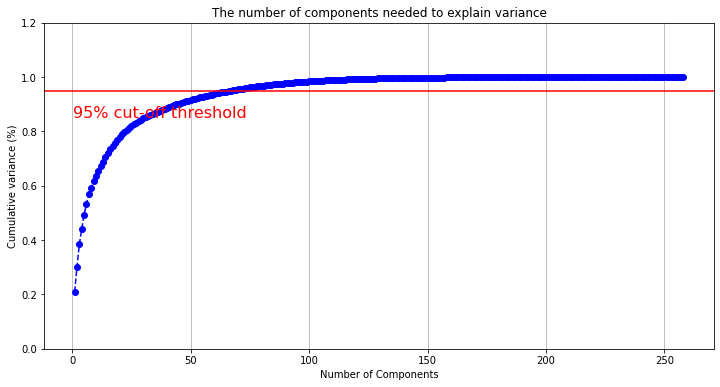

In [ ]:
pca = PCA().fit(data_designset_norm)
pca.transform(data_designset_norm)

% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 259, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.2)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### KNN hyperparameter tuning

Tuning is done for the nearest neighbors.


Best classifier: k=31
Best classifier: k=33
Best classifier: k=31
Best classifier: k=49
Best classifier: k=31
Best classifier: k=45
Best classifier: k=19
Best classifier: k=35
Best classifier: k=29
Best classifier: k=37
The optimal N=32
╒════════════╤════════════╤══════════════════════════╤═════════════╕
│   Variance │   Mean AUC │   Standard deviation AUC │   Optimal k │
╞════════════╪════════════╪══════════════════════════╪═════════════╡
│       0.95 │    0.86627 │                0.0415233 │          32 │
╘════════════╧════════════╧══════════════════════════╧═════════════╛


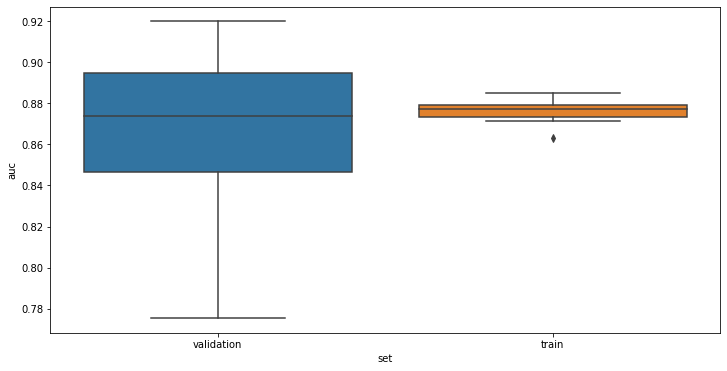

In [ ]:
n_pca = 0.95

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
k_list = list(range(1, 50, 2))
threshold = []
mean_auc_val = []
std_auc_val = []
optimal_k = []
all_train = []
all_val = []
results = []
best_n_neighbors = []

for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
  x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
  y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

  train_scores = []
  val_scores = []

  # Create a PCA with variance of n_component
  pca = PCA(n_components=n_pca)

  # Fit the PCA model, point_data_train should be a 2D numpy array
  # which has one row per subject and the pointdata as columns where
  # the columns are x1, y1, z1, x2, y2, z2, ..., xn, yn, zn
  pca.fit(x_train, y_train)

  # Transform data and create the components of the data 
  selected_data_pca_trainset = pca.transform(x_train)
  selected_data_pca_valset = pca.transform(x_val)

  # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
  # Same as above
  parameters = {"n_neighbors": list(range(1, 50, 2))}
  knn = neighbors.KNeighborsClassifier()
  cv_10fold = sss
  grid_search = GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
  grid_search.fit(selected_data_pca_trainset, y_train)
  
  # Get resulting classifier
  clf = grid_search.best_estimator_
  print(f'Best classifier: k={clf.n_neighbors}')
  best_n_neighbors.append(clf.n_neighbors)
  
  # Test the classifier on the test data
  probabilities = clf.predict_proba(selected_data_pca_valset)
  scores = probabilities[:, 1]
  
  # Get the auc
  auc = metrics.roc_auc_score(y_val, scores)
  results.append({
      'auc': auc,
      'k': clf.n_neighbors,
      'set': 'validation'
  })
    
  # Test the classifier on the validation data
  probabilities_train = clf.predict_proba(selected_data_pca_trainset)
  scores_train = probabilities_train[:, 1]
  
  # Get the auc
  auc_train = metrics.roc_auc_score(y_train, scores_train)
  results.append({
      'auc': auc_train,
      'k': clf.n_neighbors,
      'set': 'train'
  })

# Create results dataframe and plot it
plt.figure()
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")

auc_val = results[results['set'].str.contains('validation')]

threshold.append(n_pca)
mean_auc_val.append(auc_val['auc'].mean())
std_auc_val.append(auc_val['auc'].std())
optimal_k.append(int(np.median(best_n_neighbors)))
    
auc_table = {'Variance': threshold, 'Mean AUC': mean_auc_val, 'Standard deviation AUC': std_auc_val, 'Optimal k': optimal_k}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))



### SVM classifier choice

Several kernals were considered before hyperparameter tuning.

In [ ]:
# Kernels used:
kernels = ('Polynomial 2', 'Polynomial 3', 'Polynomial 4', 'Polynomial 5', 'Polynomial 6', 'Polynomial 7', 'Polynomial 8', 'Polynomial 9', 'Polynomial 10', 'RBF', 'Sigmoid','Linear')#A function which returns the corresponding SVC model
def getClassifier(ktype): 
  if ktype == 0:
      # Polynomial kernal
      return SVC(kernel='poly', degree=2, gamma="auto", probability=True, random_state=0)
  elif ktype == 1:
      # Polynomial kernal
      return SVC(kernel='poly', degree=3, gamma="auto", probability=True, random_state=0)
  elif ktype == 2:
      # Polynomial kernal
      return SVC(kernel='poly', degree=4, gamma="auto", probability=True, random_state=0)
  elif ktype == 3:
      # Polynomial kernal
      return SVC(kernel='poly', degree=5, gamma="auto", probability=True, random_state=0)
  elif ktype == 4:
      # Polynomial kernal
      return SVC(kernel='poly', degree=6, gamma="auto", probability=True, random_state=0)
  elif ktype == 5:
      # Polynomial kernal
      return SVC(kernel='poly', degree=7, gamma="auto", probability=True, random_state=0)
  elif ktype == 6:
      # Polynomial kernal
      return SVC(kernel='poly', degree=8, gamma="auto", probability=True, random_state=0)
  elif ktype == 7:
      # Polynomial kernal
      return SVC(kernel='poly', degree=9, gamma="auto", probability=True, random_state=0)
  elif ktype == 8:
      # Polynomial kernal
      return SVC(kernel='poly', degree=10, gamma="auto", probability=True, random_state=0)
  elif ktype == 9:
      # Radial Basis Function kernal
      return SVC(kernel='rbf', gamma=0.01, C=1000, probability=True, random_state=0)
  elif ktype == 10:
      # Sigmoid kernal
      return SVC(kernel='sigmoid', gamma="auto", probability=True, random_state=0)
  elif ktype == 11:
      # Linear kernal
      return SVC(kernel='linear', gamma="auto", probability=True, random_state=0)

# Apply SVC and calculate the accuracy and AUC
all_train_mean = []
all_val_mean = []
all_train_std = []
all_val_std = []
all_mean_accuracies = []
all_mean_sensitivities = []
all_mean_specificities = []

ACCURACIES = []
SPECIFICITIES = []
SENSITIVITIES = []

for ker in range(12):
  train_scores = []
  val_scores = []

  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    pca = PCA(n_components=n_pca)
    pca.fit(x_train, y_train)
    trans_train = pca.transform(x_train)
    trans_val = pca.transform(x_val)

    svclassifier = getClassifier(ker) 
    svclassifier.fit(trans_train, y_train)   # Train classifier 

    y_pred_train = svclassifier.predict(trans_train) # Apply classifier on trainset (Make prediction, label with class)
    y_pred_val = svclassifier.predict(trans_val) # Apply classifier on validationset (Make prediction, label with class)
    y_pred_train_score = svclassifier.predict_proba(trans_train)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    y_pred_val_score = svclassifier.predict_proba(trans_val)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    score_train = metrics.roc_auc_score(y_train, y_pred_train_score)
    score_val = metrics.roc_auc_score(y_val, y_pred_val_score)
    train_scores.append(score_train)
    val_scores.append(score_val)

    classification_report_val = classification_report(y_val,y_pred_val, output_dict=True)
    accuracy = classification_report_val['accuracy']
    sensitivity = classification_report_val['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
    specificity = classification_report_val['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

    ACCURACIES.append(accuracy)
    SENSITIVITIES.append(sensitivity)
    SPECIFICITIES.append(specificity)
    
  mean_accuracies = np.array(ACCURACIES).mean()
  all_mean_accuracies.append(mean_accuracies)
  mean_sensitivities = np.array(SENSITIVITIES).mean()
  all_mean_sensitivities.append(mean_sensitivities)
  mean_specificities = np.array(SPECIFICITIES).mean()
  all_mean_specificities.append(mean_specificities)

  train_scores_std = np.array(train_scores).std()
  val_scores_std = np.array(val_scores).std()

  train_scores_mean = np.array(train_scores).mean()
  val_scores_mean = np.array(val_scores).mean()

  all_train_mean.append(train_scores_mean)
  all_train_std.append(train_scores_std)
  all_val_mean.append(val_scores_mean)
  all_val_std.append(val_scores_std)
 
auc_table = {'Classifier': kernels, 'Mean AUC': all_val_mean, 'Standard deviation AUC': all_val_std, 'Mean Accuracy': all_mean_accuracies, 'Mean Sensitivity': all_mean_sensitivities, 'Mean Specificity': all_mean_specificities}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid')) 

╒═══════════════╤════════════╤══════════════════════════╤═════════════════╤════════════════════╤════════════════════╕
│ Classifier    │   Mean AUC │   Standard deviation AUC │   Mean Accuracy │   Mean Sensitivity │   Mean Specificity │
╞═══════════════╪════════════╪══════════════════════════╪═════════════════╪════════════════════╪════════════════════╡
│ Polynomial 2  │   0.663404 │                0.0718985 │        0.608696 │           1        │          0         │
├───────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ Polynomial 3  │   0.862478 │                0.0481446 │        0.608696 │           1        │          0         │
├───────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ Polynomial 4  │   0.700617 │                0.0737513 │        0.608696 │           1        │          0         │
├───────────────┼────────────┼──────────────────────────

### SVM hyperparameter tuning

Since all the kernels have more or less the same performance, all the kernels will be considered. The polynomial kernel with a degree of 3 has the best score. This will be used for further hyperparameter tuning. Tuning is done for C, gamma and kernel.

In [ ]:
ACCURACIES_poly = []
ACCURACIES_lin = []
ACCURACIES_rbf = [] 
ACCURACIES_sig = [] 
SENSITIVITIES_poly = []
SENSITIVITIES_lin = []
SENSITIVITIES_rbf = [] 
SENSITIVITIES_sig = [] 
SPECIFICITIES_poly = []
SPECIFICITIES_lin = []
SPECIFICITIES_rbf = [] 
SPECIFICITIES_sig = [] 
ROC_AUC_poly = []
ROC_AUC_lin = [] 
ROC_AUC_rbf = []
ROC_AUC_sig = []

# Create a PCA which retains number of component, such that variance is above 95%
pca = PCA(n_components=n_pca)
pca.fit(data_designset_norm, label_designset)
selected_data_pca_designset = pca.transform(data_designset_norm)
  
# defining parameter range Poly
param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['poly'], 'degree': [3]}
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')
# fitting the model for grid search
grid_search_svm.fit(selected_data_pca_designset, label_designset)
print('Poly',grid_search_svm.best_estimator_)

grid_predictions = grid_search_svm.predict(selected_data_pca_designset)
grid_predictions_score = grid_search_svm.predict_proba(selected_data_pca_designset)[:,1]
classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
accuracy = classification_report_design['accuracy']
sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

ACCURACIES_poly.append(accuracy)
SENSITIVITIES_poly.append(sensitivity)
SPECIFICITIES_poly.append(specificity)
auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
ROC_AUC_poly.append(auc_score)

# defining parameter range Linear
param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear']}
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')
# fitting the model for grid search
grid_search_svm.fit(selected_data_pca_designset, label_designset)
print('Linear',grid_search_svm.best_estimator_)

grid_predictions = grid_search_svm.predict(selected_data_pca_designset)
grid_predictions_score = grid_search_svm.predict_proba(selected_data_pca_designset)[:,1]
classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
accuracy = classification_report_design['accuracy']
sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

ACCURACIES_lin.append(accuracy)
SENSITIVITIES_lin.append(sensitivity)
SPECIFICITIES_lin.append(specificity)
auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
ROC_AUC_lin.append(auc_score)

# defining parameter range RBF
param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

# fitting the model for grid search
grid_search_svm.fit(selected_data_pca_designset, label_designset)
print('RBF',grid_search_svm.best_estimator_)

grid_predictions = grid_search_svm.predict(selected_data_pca_designset)
grid_predictions_score = grid_search_svm.predict_proba(selected_data_pca_designset)[:,1]
classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
accuracy = classification_report_design['accuracy']
sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

ACCURACIES_rbf.append(accuracy)
SENSITIVITIES_rbf.append(sensitivity)
SPECIFICITIES_rbf.append(specificity)
auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
ROC_AUC_rbf.append(auc_score)

# defining parameter range Sigmoid
param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['sigmoid']}
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

# fitting the model for grid search
grid_search_svm.fit(selected_data_pca_designset, label_designset)
print('Sigmoid',grid_search_svm.best_estimator_)

grid_predictions = grid_search_svm.predict(selected_data_pca_designset)
grid_predictions_score = grid_search_svm.predict_proba(selected_data_pca_designset)[:,1]
classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
accuracy = classification_report_design['accuracy']
sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

ACCURACIES_sig.append(accuracy)
SENSITIVITIES_sig.append(sensitivity)
SPECIFICITIES_sig.append(specificity)
auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
ROC_AUC_sig.append(auc_score)

print(f'Accuracies: {ACCURACIES_poly} \n {ACCURACIES_lin} \n {ACCURACIES_rbf} \n {ACCURACIES_sig}')
print(f'ROC AUC scores: {ROC_AUC_poly} \n {ROC_AUC_lin} \n {ROC_AUC_rbf} \n {ROC_AUC_sig}')

Fitting 10 folds for each of 28 candidates, totalling 280 fits
Poly SVC(C=0.001, gamma=1, kernel='poly', probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Linear SVC(C=0.1, gamma=1, kernel='linear', probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
RBF SVC(C=10, gamma=0.01, probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Sigmoid SVC(C=100, gamma=0.001, kernel='sigmoid', probability=True)
Accuracies: [0.783625730994152] 
 [0.8450292397660819] 
 [0.8611111111111112] 
 [0.8450292397660819]
ROC AUC scores: [0.9433600573296905] 
 [0.9116047834460518] 
 [0.9232767501231692] 
 [0.9116047834460519]


In [ ]:
classifier_names = ['Polynomial 3','Linear','RBF','Sigmoid']
n_component_names = ['0.95', '', '', '']
mean_auc_scores = [ROC_AUC_poly[0], ROC_AUC_lin[0], ROC_AUC_rbf[0], ROC_AUC_sig[0]]
accuracies_combined = [ACCURACIES_poly[0], ACCURACIES_lin[0], ACCURACIES_rbf[0], ACCURACIES_sig[0]] 
sensitivities_combined = [SENSITIVITIES_poly[0], SENSITIVITIES_lin[0], SENSITIVITIES_rbf[0], SENSITIVITIES_sig[0]] 
specificities_combined = [SPECIFICITIES_poly[0], SPECIFICITIES_lin[0], SPECIFICITIES_rbf[0], SPECIFICITIES_sig[0]] 
auc_table = {'Number of Components Percentile': n_component_names, 'Classifier': classifier_names, 'Mean AUC score': mean_auc_scores, 'Accuracy': accuracies_combined, 'Sensitivity': sensitivities_combined, 'Specificity': specificities_combined}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid')) 

╒═══════════════════════════════════╤══════════════╤══════════════════╤════════════╤═══════════════╤═══════════════╕
│ Number of Components Percentile   │ Classifier   │   Mean AUC score │   Accuracy │   Sensitivity │   Specificity │
╞═══════════════════════════════════╪══════════════╪══════════════════╪════════════╪═══════════════╪═══════════════╡
│ 0.95                              │ Polynomial 3 │         0.94336  │   0.783626 │      0.995181 │      0.457249 │
├───────────────────────────────────┼──────────────┼──────────────────┼────────────┼───────────────┼───────────────┤
│                                   │ Linear       │         0.911605 │   0.845029 │      0.918072 │      0.732342 │
├───────────────────────────────────┼──────────────┼──────────────────┼────────────┼───────────────┼───────────────┤
│                                   │ RBF          │         0.923277 │   0.861111 │      0.93253  │      0.750929 │
├───────────────────────────────────┼──────────────┼────────────

Based on the table above the following hyperparameters are used for the classification: 
*   Polynomal third degree: C=0.001, gamma=1
*   Linear: C=0.1, gamma=1
*   RBF: C=10, gamma=0.01
*   Sigmoid: C=100, gamma=0.001

### Optimized classifiers

In [ ]:
# Which kernels do we use:
kernels = ('SVM Polynomial 3', 'SVM Linear', 'SVM RBF', 'SVM Sigmoid', 'K-Nearest Neighbor')
def getClassifier(ktype): 
  if ktype == 0:
      # Support Vector Machine Polynomial kernel
      return SVC(kernel='poly', degree=3, C=0.001, gamma=1, probability=True, random_state=0)
  elif ktype == 1:
      # Support Vector Machine Linear kernel
      return SVC(kernel='linear', C=0.1, gamma=1, probability=True, random_state=0)
  elif ktype == 2:
      # Support Vector Machine Radial Basis Function kernel
      return SVC(kernel='rbf', C=10, gamma=0.01, probability=True, random_state=0)
  elif ktype == 3:
      # Support Vector Machine Sigmoid kernel
      return SVC(kernel='sigmoid', C=100, gamma=0.001, probability=True, random_state=0)
  elif ktype == 4: 
      # K-Nearest Neighbor classifier
       return neighbors.KNeighborsClassifier(n_neighbors=32)
  
# Apply SVC and calculate the accuracy and AUC
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)

all_train_mean = []
all_val_mean = []
all_train_std = []
all_val_std = []
all_mean_accuracies = []
all_mean_sensitivities = []
all_mean_specificities = []

n_pca = 0.95
names_clfs = ['SVM (poly)', 'SVM (linear)', 'SVM (rbf)', 'SVM (sigmoid)', 'KNN']
   
for ker, clasf in zip(range(5), names_clfs):
  train_scores = []
  val_scores = []
  ACCURACIES = []
  SPECIFICITIES = []
  SENSITIVITIES = []

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  
  for j, (train_idx, val_idx) in enumerate(sss.split(data_designset_norm,label_designset)): # split data
    
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    pca = PCA(n_components=n_pca)
    pca.fit(x_train, y_train)
    trans_train = pca.transform(x_train)
    trans_val = pca.transform(x_val)
    
    selected_classifier = getClassifier(ker) 
    selected_classifier.fit(trans_train, y_train)   # Train classifier 

    # VALIDATION
    y_pred_train = selected_classifier.predict(trans_train) # Apply classifier on trainset (Make prediction, label with class)
    y_pred_train_score = selected_classifier.predict_proba(trans_train)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    y_pred_val = selected_classifier.predict(trans_val) # Apply classifier on validationset (Make prediction, label with class)
    y_pred_val_score = selected_classifier.predict_proba(trans_val)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    score_train = metrics.roc_auc_score(y_train, y_pred_train_score)
    score_val = metrics.roc_auc_score(y_val, y_pred_val_score)
    
    train_scores.append(score_train)
    val_scores.append(score_val)

    classification_report_val = classification_report(y_val,y_pred_val, output_dict=True)
    accuracy = classification_report_val['accuracy']
    sensitivity = classification_report_val['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
    specificity = classification_report_val['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

    ACCURACIES.append(accuracy)
    SENSITIVITIES.append(sensitivity)
    SPECIFICITIES.append(specificity)

  # VALIDATION
  
  mean_accuracies = np.array(ACCURACIES).mean()
  all_mean_accuracies.append(mean_accuracies)
  mean_sensitivities = np.array(SENSITIVITIES).mean()
  all_mean_sensitivities.append(mean_sensitivities)
  mean_specificities = np.array(SPECIFICITIES).mean()
  all_mean_specificities.append(mean_specificities)

  train_scores_std = np.array(train_scores).std()
  val_scores_std = np.array(val_scores).std()

  train_scores_mean = np.array(train_scores).mean()
  val_scores_mean = np.array(val_scores).mean()

  all_train_mean.append(train_scores_mean)
  all_train_std.append(train_scores_std)
  all_val_mean.append(val_scores_mean)
  all_val_std.append(val_scores_std)

auc_table = {'Classifier': kernels, 'Mean AUC': all_val_mean, 'Standard deviation AUC': all_val_std, 'Mean Accuracy': all_mean_accuracies, 'Mean Sensitivity': all_mean_sensitivities, 'Mean Specificity': all_mean_specificities}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))

╒════════════════════╤════════════╤══════════════════════════╤═════════════════╤════════════════════╤════════════════════╕
│ Classifier         │   Mean AUC │   Standard deviation AUC │   Mean Accuracy │   Mean Sensitivity │   Mean Specificity │
╞════════════════════╪════════════╪══════════════════════════╪═════════════════╪════════════════════╪════════════════════╡
│ SVM Polynomial 3   │   0.875661 │                0.0405471 │        0.750725 │           0.969048 │           0.411111 │
├────────────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ SVM Linear         │   0.898589 │                0.0340918 │        0.842029 │           0.890476 │           0.766667 │
├────────────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ SVM RBF            │   0.900353 │                0.0325635 │        0.847826 │           0.9      │           0.766667 │
├───────────────

## Univariate feature selection + principle component analysis

### KNN hyperparameter tuning

Best classifier: k=31
Best classifier: k=33
Best classifier: k=31
Best classifier: k=49
Best classifier: k=31
Best classifier: k=45
Best classifier: k=19
Best classifier: k=35
Best classifier: k=29
Best classifier: k=37
The optimal N=32
Best classifier: k=39
Best classifier: k=41
Best classifier: k=43
Best classifier: k=27
Best classifier: k=49
Best classifier: k=33
Best classifier: k=43
Best classifier: k=31
Best classifier: k=49
Best classifier: k=29
The optimal N=40
Best classifier: k=11
Best classifier: k=45
Best classifier: k=45
Best classifier: k=31
Best classifier: k=7
Best classifier: k=49
Best classifier: k=35
Best classifier: k=39
Best classifier: k=49
Best classifier: k=33
The optimal N=37
Best classifier: k=23
Best classifier: k=23
Best classifier: k=23
Best classifier: k=31
Best classifier: k=11
Best classifier: k=17
Best classifier: k=25
Best classifier: k=23
Best classifier: k=19
Best classifier: k=23
The optimal N=23
Best classifier: k=49
Best classifier: k=13
Best clas

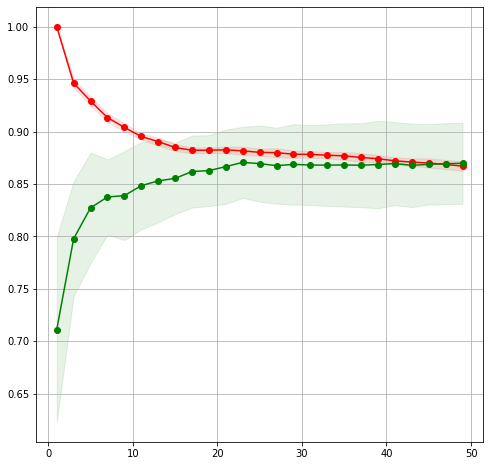

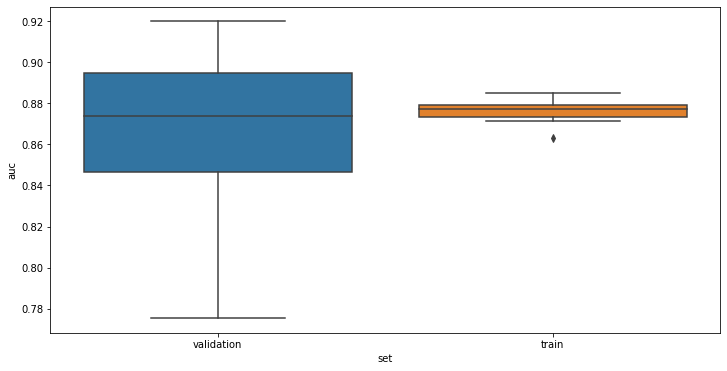

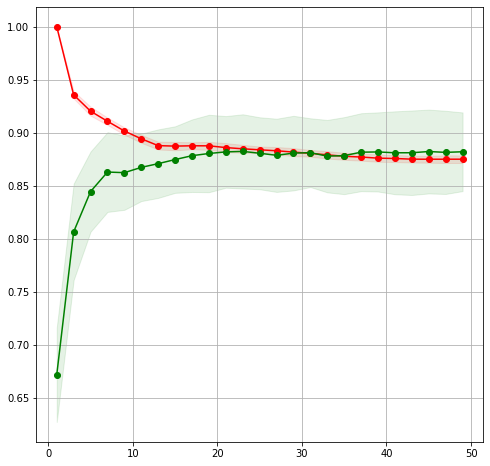

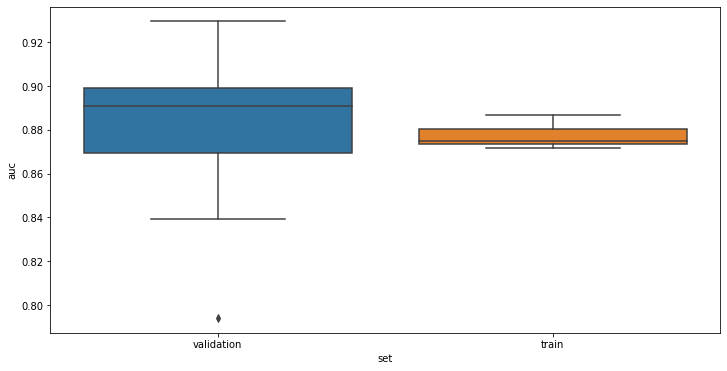

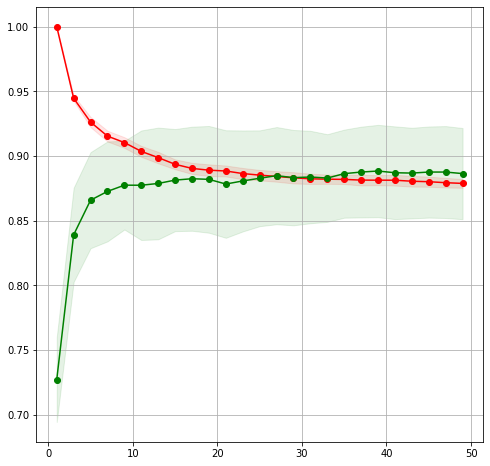

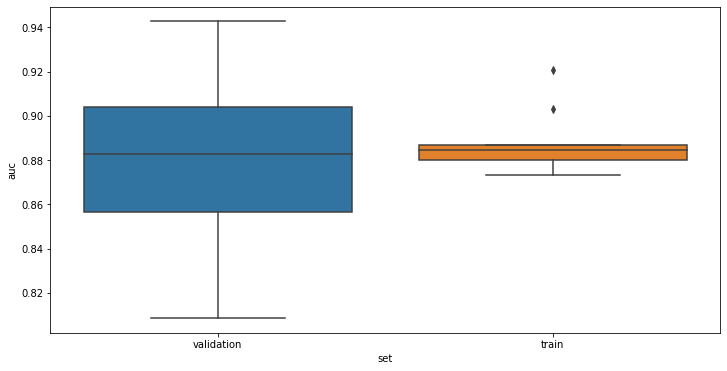

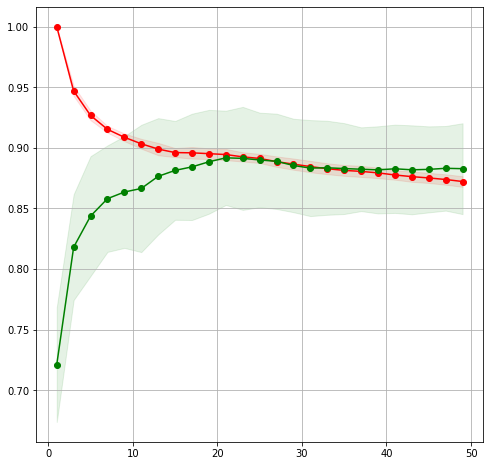

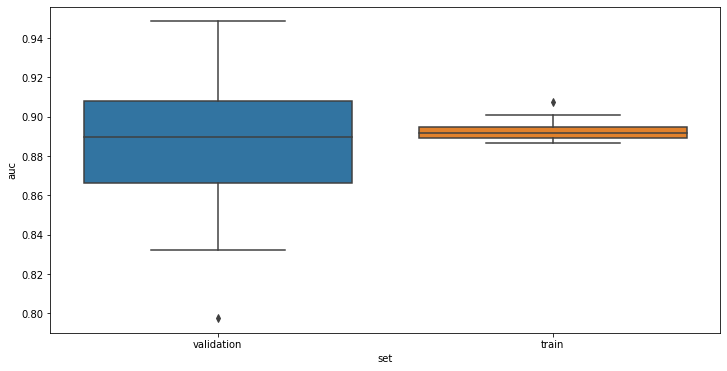

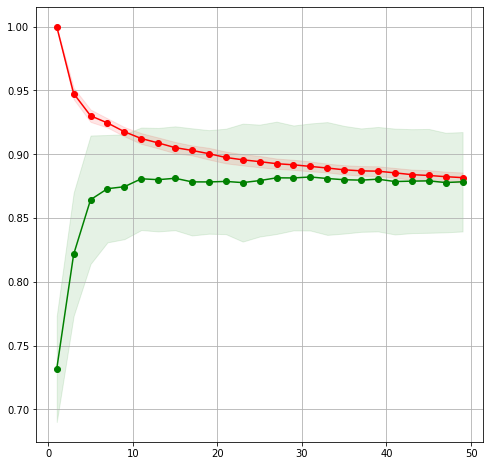

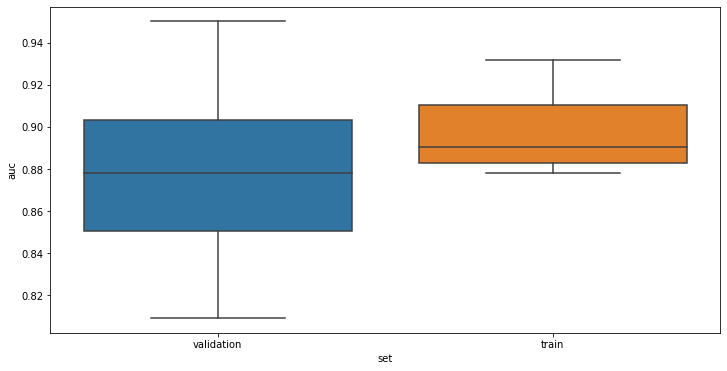

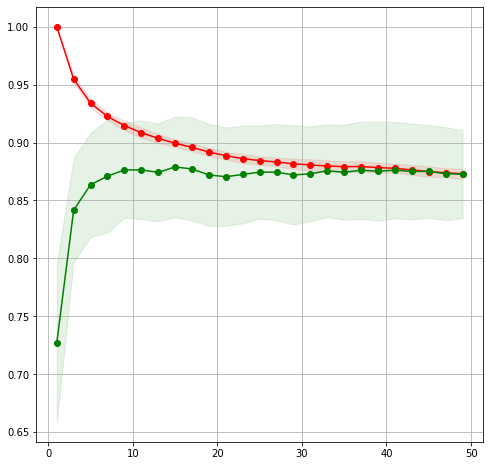

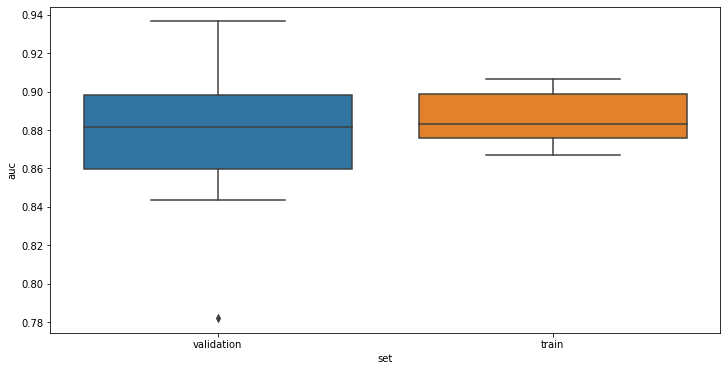

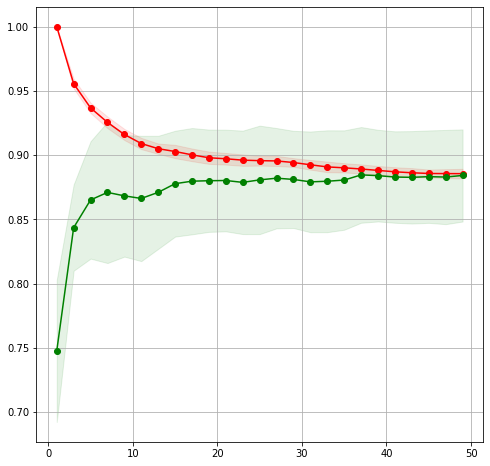

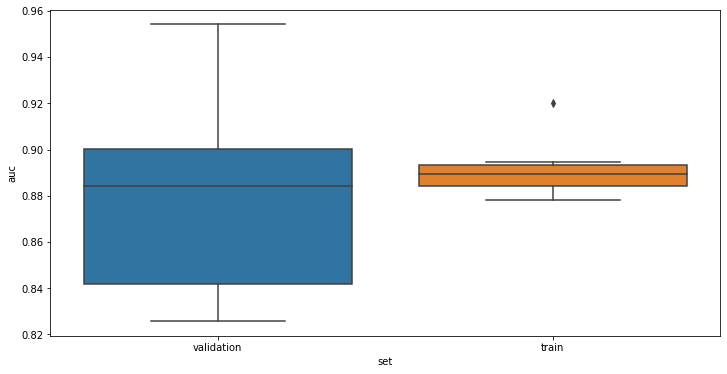

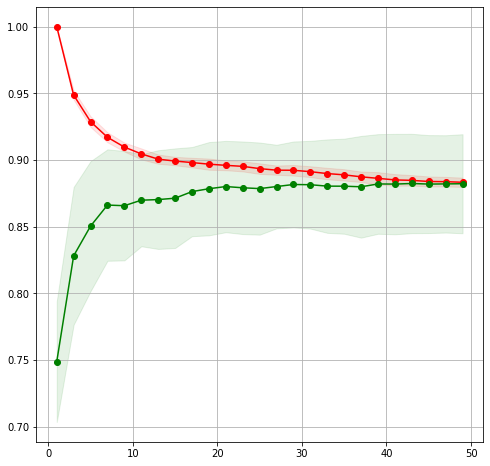

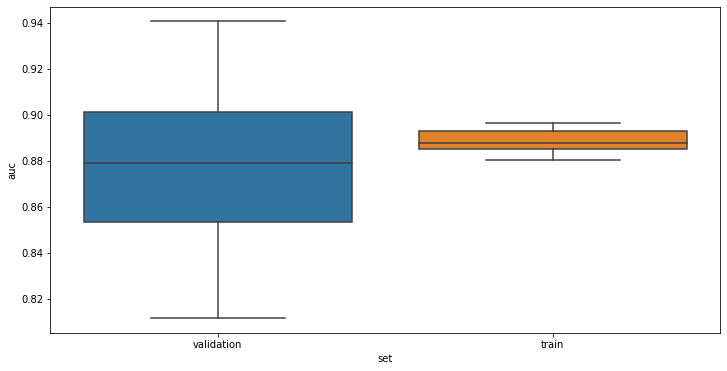

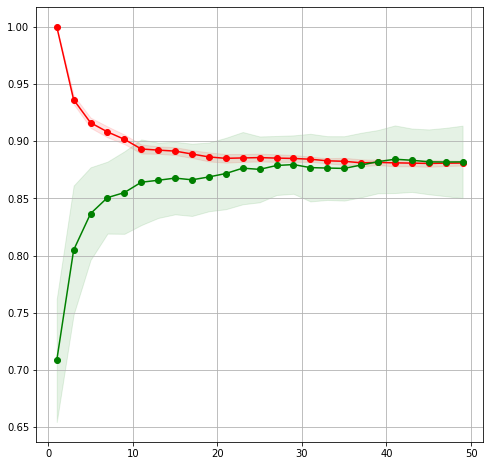

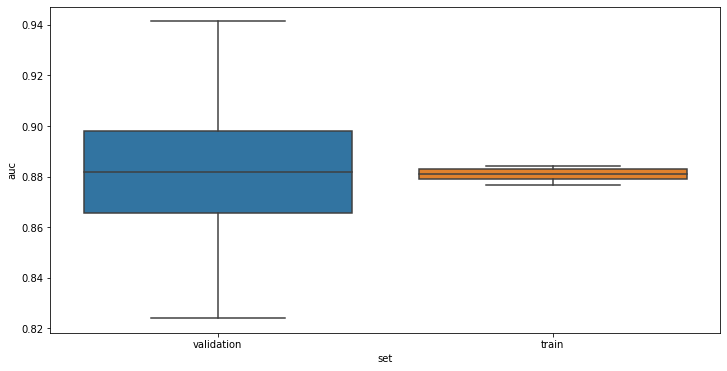

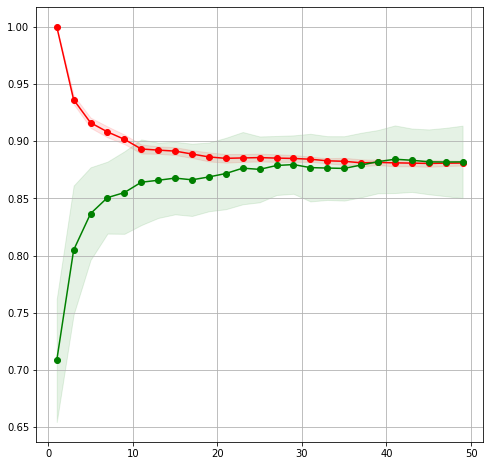

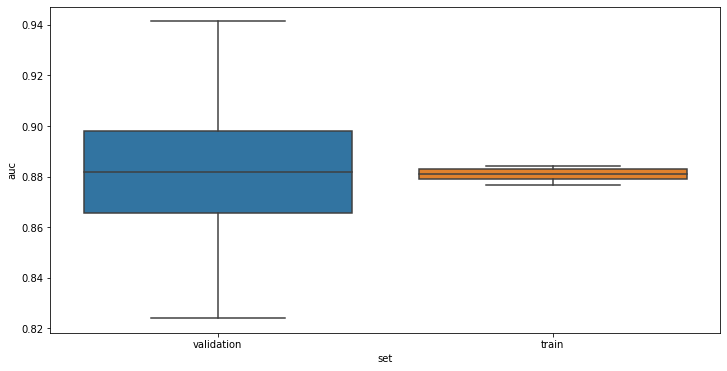

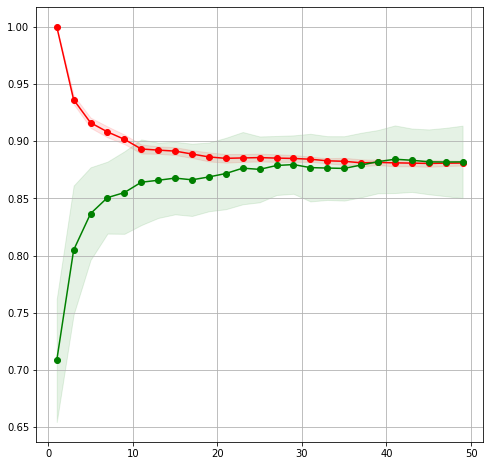

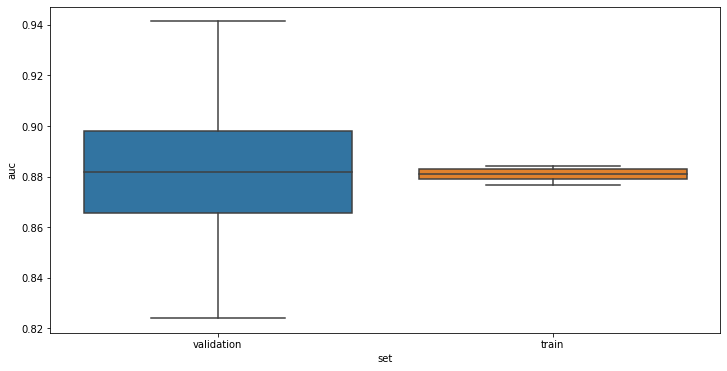

In [ ]:
k_list = list(range(1, 50, 2))
threshold_values = []
mean_auc_val = []
std_auc_val = []
optimal_k = []

thresholds = range(11)
for threshold in thresholds:
  all_train = []
  all_val = []
  results = []
  best_n_neighbors = []

  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    train_scores = []
    val_scores = []
    selected_data_univ_designset_norm = data_designset_norm[most_counted_selected_features[threshold]]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]

    pca = PCA(n_components=n_pca)
    pca.fit(selected_data_univ_trainset_norm, label_designset)
    selected_data_pca_trainset = pca.transform(selected_data_univ_trainset_norm)
    selected_data_pca_valset = pca.transform(selected_data_univ_valset_norm)
    
    # Aplly K-Nearest Neighbor classifier to features selected with univariate
    for k in k_list: 
      clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
      clf_knn.fit(selected_data_pca_trainset, y_train)

      # Test the classifier on the selected features from the training data and plot 
      train_proba = clf_knn.predict_proba(selected_data_pca_trainset)[:,1]
      val_proba = clf_knn.predict_proba(selected_data_pca_valset)[:,1]

      score_train = metrics.roc_auc_score(y_train, train_proba)
      score_val = metrics.roc_auc_score(y_val, val_proba)

      train_scores.append(score_train)
      val_scores.append(score_val)

    all_train.append(train_scores)
    all_val.append(val_scores)

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 50, 2))}
    knn = neighbors.KNeighborsClassifier()
    grid_search = GridSearchCV(knn, parameters, cv=sss, scoring='roc_auc')
    grid_search.fit(selected_data_pca_trainset, y_train)
    pd.DataFrame(grid_search.cv_results_)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(selected_data_pca_valset)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_val, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
    # Test the classifier on the validation data
    probabilities_train = clf.predict_proba(selected_data_pca_trainset)
    scores_train = probabilities_train[:, 1]
    
    # Get the auc
    auc_train = metrics.roc_auc_score(y_train, scores_train)
    results.append({
        'auc': auc_train,
        'k': clf.n_neighbors,
        'set': 'train'
    })
    
  # Calculate the mean and std
  all_train = np.array(all_train)
  all_val = np.array(all_val)

  train_scores_mean = all_train.mean(axis=0)
  val_scores_mean = all_val.mean(axis=0)

  train_scores_std = all_train.std(axis=0)
  val_scores_std = all_val.std(axis=0)

  # Plot the mean scores and the std as shading
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  ax.grid()
  ax.fill_between(k_list, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
  ax.fill_between(k_list, val_scores_mean - val_scores_std,
                      val_scores_mean + val_scores_std, alpha=0.1,
                      color="g")
  ax.plot(k_list, train_scores_mean, 'o-', color="r",
          label="Training score")
  ax.plot(k_list, val_scores_mean, 'o-', color="g",
          label="Validation score")
  
  # Create results dataframe and plot it
  plt.figure()
  results = pd.DataFrame(results)
  sns.boxplot(y='auc', x='set', data=results)

  auc_val = results[results['set'].str.contains('validation')]
  threshold_values.append(threshold*0.1)
  mean_auc_val.append(auc_val['auc'].mean())
  std_auc_val.append(auc_val['auc'].std())
  optimal_k.append(int(np.median(best_n_neighbors)))

  optimal_n = int(np.median(best_n_neighbors))
  print(f"The optimal N={optimal_n}")

auc_table = {'Threshold': threshold_values, 'Mean AUC': mean_auc_val, 'Standard deviation AUC': std_auc_val, 'Optimal k': optimal_k}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))


The optimal threshold is 0.3 and the optimal k is 23.

### SVM classifier choice

Several kernals were considered before hyperparameter tuning.

In [ ]:
# Kernels used:
kernels = ('Polynomial 2', 'Polynomial 3', 'Polynomial 4', 'Polynomial 5', 'Polynomial 6', 'Polynomial 7', 'Polynomial 8', 'Polynomial 9', 'Polynomial 10', 'RBF', 'Sigmoid','Linear')#A function which returns the corresponding SVC model
def getClassifier(ktype): 
  if ktype == 0:
      # Polynomial kernal
      return SVC(kernel='poly', degree=2, gamma="auto", probability=True, random_state=0)
  elif ktype == 1:
      # Polynomial kernal
      return SVC(kernel='poly', degree=3, gamma="auto", probability=True, random_state=0)
  elif ktype == 2:
      # Polynomial kernal
      return SVC(kernel='poly', degree=4, gamma="auto", probability=True, random_state=0)
  elif ktype == 3:
      # Polynomial kernal
      return SVC(kernel='poly', degree=5, gamma="auto", probability=True, random_state=0)
  elif ktype == 4:
      # Polynomial kernal
      return SVC(kernel='poly', degree=6, gamma="auto", probability=True, random_state=0)
  elif ktype == 5:
      # Polynomial kernal
      return SVC(kernel='poly', degree=7, gamma="auto", probability=True, random_state=0)
  elif ktype == 6:
      # Polynomial kernal
      return SVC(kernel='poly', degree=8, gamma="auto", probability=True, random_state=0)
  elif ktype == 7:
      # Polynomial kernal
      return SVC(kernel='poly', degree=9, gamma="auto", probability=True, random_state=0)
  elif ktype == 8:
      # Polynomial kernal
      return SVC(kernel='poly', degree=10, gamma="auto", probability=True, random_state=0)
  elif ktype == 9:
      # Radial Basis Function kernal
      return SVC(kernel='rbf', gamma=0.01, C=1000, probability=True, random_state=0)
  elif ktype == 10:
      # Sigmoid kernal
      return SVC(kernel='sigmoid', gamma="auto", probability=True, random_state=0)
  elif ktype == 11:
      # Linear kernal
      return SVC(kernel='linear', gamma="auto", probability=True, random_state=0)

# Apply SVC and calculate the accuracy and AUC
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
all_train_mean = []
all_val_mean = []
all_train_std = []
all_val_std = []
all_mean_accuracies = []
all_mean_sensitivities = []
all_mean_specificities = []

ACCURACIES = []
SPECIFICITIES = []
SENSITIVITIES = []

for ker in range(12):
  train_scores = []
  val_scores = []

  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    
    selected_data_univ_designset_norm = data_designset_norm[most_counted_selected_features[5]]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]

    pca = PCA(n_components=n_pca)
    pca.fit(selected_data_univ_trainset_norm, label_designset)
    selected_data_pca_trainset = pca.transform(selected_data_univ_trainset_norm)
    selected_data_pca_valset = pca.transform(selected_data_univ_valset_norm)
    
    svclassifier = getClassifier(ker) 
    svclassifier.fit(selected_data_pca_trainset, y_train)   # Train classifier 

    y_pred_train = svclassifier.predict(selected_data_pca_trainset) # Apply classifier on trainset (Make prediction, label with class)
    y_pred_val = svclassifier.predict(selected_data_pca_valset) # Apply classifier on validationset (Make prediction, label with class)
    y_pred_train_score = svclassifier.predict_proba(selected_data_pca_trainset)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    y_pred_val_score = svclassifier.predict_proba(selected_data_pca_valset)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    score_train = metrics.roc_auc_score(y_train, y_pred_train_score)
    score_val = metrics.roc_auc_score(y_val, y_pred_val_score)
    train_scores.append(score_train)
    val_scores.append(score_val)

    classification_report_val = classification_report(y_val,y_pred_val, output_dict=True)
    accuracy = classification_report_val['accuracy']
    sensitivity = classification_report_val['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
    specificity = classification_report_val['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

    ACCURACIES.append(accuracy)
    SENSITIVITIES.append(sensitivity)
    SPECIFICITIES.append(specificity)
    
  mean_accuracies = np.array(ACCURACIES).mean()
  all_mean_accuracies.append(mean_accuracies)
  mean_sensitivities = np.array(SENSITIVITIES).mean()
  all_mean_sensitivities.append(mean_sensitivities)
  mean_specificities = np.array(SPECIFICITIES).mean()
  all_mean_specificities.append(mean_specificities)

  train_scores_std = np.array(train_scores).std()
  val_scores_std = np.array(val_scores).std()

  train_scores_mean = np.array(train_scores).mean()
  val_scores_mean = np.array(val_scores).mean()

  all_train_mean.append(train_scores_mean)
  all_train_std.append(train_scores_std)
  all_val_mean.append(val_scores_mean)
  all_val_std.append(val_scores_std)
 
auc_table = {'Classifier': kernels, 'Mean AUC': all_val_mean, 'Standard deviation AUC': all_val_std, 'Mean Accuracy': all_mean_accuracies, 'Mean Sensitivity': all_mean_sensitivities, 'Mean Specificity': all_mean_specificities}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid')) 


╒═══════════════╤════════════╤══════════════════════════╤═════════════════╤════════════════════╤════════════════════╕
│ Classifier    │   Mean AUC │   Standard deviation AUC │   Mean Accuracy │   Mean Sensitivity │   Mean Specificity │
╞═══════════════╪════════════╪══════════════════════════╪═════════════════╪════════════════════╪════════════════════╡
│ Polynomial 2  │   0.654409 │                0.0599874 │        0.713043 │           0.990476 │           0.281481 │
├───────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ Polynomial 3  │   0.852822 │                0.0383764 │        0.726812 │           0.986905 │           0.322222 │
├───────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ Polynomial 4  │   0.648148 │                0.0595979 │        0.708696 │           0.989683 │           0.271605 │
├───────────────┼────────────┼──────────────────────────

### SVM hyperparameter tuning

In [ ]:
ACCURACIES_poly = []
ACCURACIES_lin = []
ACCURACIES_rbf = [] 
ACCURACIES_sig = [] 
SENSITIVITIES_poly = []
SENSITIVITIES_lin = []
SENSITIVITIES_rbf = [] 
SENSITIVITIES_sig = [] 
SPECIFICITIES_poly = []
SPECIFICITIES_lin = []
SPECIFICITIES_rbf = [] 
SPECIFICITIES_sig = [] 
ROC_AUC_poly = []
ROC_AUC_lin = [] 
ROC_AUC_rbf = []
ROC_AUC_sig = []

thresholds = range(2, 11)
n_pca = 0.95

for threshold in thresholds:
  print(f'New loop with threshold: {threshold}')
  selected_data_univ_designset_norm = data_designset_norm[most_counted_selected_features[threshold]]

  # Create a PCA which retains number of component, such that variance is above 95%
  pca = PCA(n_components=n_pca)
  pca.fit(selected_data_univ_designset_norm, label_designset)
  selected_data_pca_designset = pca.transform(selected_data_univ_designset_norm)

  # defining parameter range Poly
  param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['poly'], 'degree': [3]}
  grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_pca_designset, label_designset)
  print('Poly',grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_pca_designset)
  grid_predictions_score = grid_search_svm.predict_proba(selected_data_pca_designset)[:,1]
  classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
  accuracy = classification_report_design['accuracy']
  sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
  specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

  ACCURACIES_poly.append(accuracy)
  SENSITIVITIES_poly.append(sensitivity)
  SPECIFICITIES_poly.append(specificity)
  auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
  ROC_AUC_poly.append(auc_score)

  # defining parameter range Linear
  param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear']}
  grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_pca_designset, label_designset)
  print('Linear',grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_pca_designset)
  grid_predictions_score = grid_search_svm.predict_proba(selected_data_pca_designset)[:,1]
  classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
  accuracy = classification_report_design['accuracy']
  sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
  specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

  ACCURACIES_lin.append(accuracy)
  SENSITIVITIES_lin.append(sensitivity)
  SPECIFICITIES_lin.append(specificity)
  auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
  ROC_AUC_lin.append(auc_score)

  # defining parameter range RBF
  param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
  grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_pca_designset, label_designset)
  print('RBF',grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_pca_designset)
  grid_predictions_score = grid_search_svm.predict_proba(selected_data_pca_designset)[:,1]
  classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
  accuracy = classification_report_design['accuracy']
  sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
  specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

  ACCURACIES_rbf.append(accuracy)
  SENSITIVITIES_rbf.append(sensitivity)
  SPECIFICITIES_rbf.append(specificity)
  auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
  ROC_AUC_rbf.append(auc_score)

  # defining parameter range Sigmoid
  param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['sigmoid']}
  grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_pca_designset, label_designset)
  print('Sigmoid',grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_pca_designset)
  grid_predictions_score = grid_search_svm.predict_proba(selected_data_pca_designset)[:,1]
  classification_report_design = classification_report(label_designset,grid_predictions, output_dict=True)
  accuracy = classification_report_design['accuracy']
  sensitivity = classification_report_design['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
  specificity = classification_report_design['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

  ACCURACIES_sig.append(accuracy)
  SENSITIVITIES_sig.append(sensitivity)
  SPECIFICITIES_sig.append(specificity)
  auc_score = metrics.roc_auc_score(label_designset, grid_predictions_score)
  ROC_AUC_sig.append(auc_score)

print(f'Accuracies: {ACCURACIES_poly} \n {ACCURACIES_lin} \n {ACCURACIES_rbf} \n {ACCURACIES_sig}')
print(f'ROC AUC scores: {ROC_AUC_poly} \n {ROC_AUC_lin} \n {ROC_AUC_rbf} \n {ROC_AUC_sig}')

classifier_names = ['Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid', 'Polynomial 3','Linear','RBF','Sigmoid']
n_component_names = ['0.2', '', '', '','0.3', '', '', '', '0.4', '', '', '', '0.5', '', '', '', '0.6', '', '', '', '0.7', '', '', '', '0.8', '', '', '', '0.9', '', '', '', '1.0', '', '', '']
mean_auc_scores = [ROC_AUC_poly[0], ROC_AUC_lin[0], ROC_AUC_rbf[0], ROC_AUC_sig[0],ROC_AUC_poly[1], ROC_AUC_lin[1], ROC_AUC_rbf[1], ROC_AUC_sig[1],ROC_AUC_poly[2], ROC_AUC_lin[2], ROC_AUC_rbf[2], ROC_AUC_sig[2], ROC_AUC_poly[3], ROC_AUC_lin[3], ROC_AUC_rbf[3], ROC_AUC_sig[3],ROC_AUC_poly[4], ROC_AUC_lin[4], ROC_AUC_rbf[4], ROC_AUC_sig[4],ROC_AUC_poly[5], ROC_AUC_lin[5], ROC_AUC_rbf[5], ROC_AUC_sig[5],ROC_AUC_poly[6], ROC_AUC_lin[6], ROC_AUC_rbf[6], ROC_AUC_sig[6] ,ROC_AUC_poly[7], ROC_AUC_lin[7], ROC_AUC_rbf[7], ROC_AUC_sig[7] ,ROC_AUC_poly[8], ROC_AUC_lin[8], ROC_AUC_rbf[8], ROC_AUC_sig[8]]
accuracies_combined = [ACCURACIES_poly[0], ACCURACIES_lin[0], ACCURACIES_rbf[0], ACCURACIES_sig[0], ACCURACIES_poly[1], ACCURACIES_lin[1], ACCURACIES_rbf[1], ACCURACIES_sig[1], ACCURACIES_poly[2], ACCURACIES_lin[2], ACCURACIES_rbf[2], ACCURACIES_sig[2], ACCURACIES_poly[3], ACCURACIES_lin[3], ACCURACIES_rbf[3], ACCURACIES_sig[3], ACCURACIES_poly[4], ACCURACIES_lin[4], ACCURACIES_rbf[4], ACCURACIES_sig[4], ACCURACIES_poly[5], ACCURACIES_lin[5], ACCURACIES_rbf[5], ACCURACIES_sig[5], ACCURACIES_poly[6], ACCURACIES_lin[6], ACCURACIES_rbf[6], ACCURACIES_sig[6], ACCURACIES_poly[7], ACCURACIES_lin[7], ACCURACIES_rbf[7], ACCURACIES_sig[7], ACCURACIES_poly[8], ACCURACIES_lin[8], ACCURACIES_rbf[8], ACCURACIES_sig[8]] 
sensitivities_combined = [SENSITIVITIES_poly[0], SENSITIVITIES_lin[0], SENSITIVITIES_rbf[0], SENSITIVITIES_sig[0], SENSITIVITIES_poly[1], SENSITIVITIES_lin[1], SENSITIVITIES_rbf[1], SENSITIVITIES_sig[1], SENSITIVITIES_poly[2], SENSITIVITIES_lin[2], SENSITIVITIES_rbf[2], SENSITIVITIES_sig[2], SENSITIVITIES_poly[3], SENSITIVITIES_lin[3], SENSITIVITIES_rbf[3], SENSITIVITIES_sig[3], SENSITIVITIES_poly[4], SENSITIVITIES_lin[4], SENSITIVITIES_rbf[4], SENSITIVITIES_sig[4], SENSITIVITIES_poly[5], SENSITIVITIES_lin[5], SENSITIVITIES_rbf[5], SENSITIVITIES_sig[5], SENSITIVITIES_poly[6], SENSITIVITIES_lin[6], SENSITIVITIES_rbf[6], SENSITIVITIES_sig[6], SENSITIVITIES_poly[7], SENSITIVITIES_lin[7], SENSITIVITIES_rbf[7], SENSITIVITIES_sig[7], SENSITIVITIES_poly[8], SENSITIVITIES_lin[8], SENSITIVITIES_rbf[8], SENSITIVITIES_sig[8]] 
specificities_combined = [SPECIFICITIES_poly[0], SPECIFICITIES_lin[0], SPECIFICITIES_rbf[0], SPECIFICITIES_sig[0], SPECIFICITIES_poly[1], SPECIFICITIES_lin[1], SPECIFICITIES_rbf[1], SPECIFICITIES_sig[1], SPECIFICITIES_poly[2], SPECIFICITIES_lin[2], SPECIFICITIES_rbf[2], SENSITIVITIES_sig[2], SPECIFICITIES_poly[3], SPECIFICITIES_lin[3], SPECIFICITIES_rbf[3], SPECIFICITIES_sig[3], SPECIFICITIES_poly[4], SPECIFICITIES_lin[4], SPECIFICITIES_rbf[4], SPECIFICITIES_sig[4], SPECIFICITIES_poly[5], SPECIFICITIES_lin[5], SPECIFICITIES_rbf[5], SPECIFICITIES_sig[5], SPECIFICITIES_poly[6], SPECIFICITIES_lin[6], SPECIFICITIES_rbf[6], SPECIFICITIES_sig[6], SPECIFICITIES_poly[7], SPECIFICITIES_lin[7], SPECIFICITIES_rbf[7], SPECIFICITIES_sig[7], SPECIFICITIES_poly[8], SPECIFICITIES_lin[8], SPECIFICITIES_rbf[8], SPECIFICITIES_sig[8]] 
auc_table = {'Relative Thresholds': n_component_names, 'Classifier': classifier_names, 'Mean AUC score': mean_auc_scores, 'Accuracy': accuracies_combined, 'Sensitivity': sensitivities_combined, 'Specificity': specificities_combined}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))


New loop with threshold: 2
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Poly SVC(C=100, gamma=0.1, kernel='poly', probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Linear SVC(C=1, gamma=1, kernel='linear', probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
RBF SVC(C=10, gamma=0.1, probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Sigmoid SVC(C=10, gamma=0.1, kernel='sigmoid', probability=True)
New loop with threshold: 3
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Poly SVC(C=1, gamma=1, kernel='poly', probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Linear SVC(C=10, gamma=1, kernel='linear', probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
RBF SVC(C=10, gamma=1, probability=True)
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Sigmoid SVC(C=1000, gamma=0.01, kernel='sigmoid', probab

### Optimized classifiers

In [ ]:
# Which kernels do we use:
kernels = ('SVM Polynomial 3', 'SVM Linear', 'SVM RBF', 'SVM Sigmoid', 'K-Nearest Neighbor')#A function which returns the corresponding SVC model
def getClassifier(ktype): 
  if ktype == 0:
      # Support Vector Machine Polynomial kernel
      return SVC(kernel='poly', degree=3, C=100, gamma=0.1, probability=True, random_state=0)
  elif ktype == 1:
      # Support Vector Machine Linear kernel
      return SVC(kernel='linear', C=1, gamma=1, probability=True, random_state=0)
  elif ktype == 2:
      # Support Vector Machine Radial Basis Function kernel
      return SVC(kernel='rbf', C=10, gamma=1, probability=True, random_state=0)
  elif ktype == 3:
      # Support Vector Machine Sigmoid kernel
      return SVC(kernel='sigmoid', C=10, gamma=0.1, probability=True, random_state=0)
  elif ktype == 4: 
      # K-Nearest Neighbor classifier
       return neighbors.KNeighborsClassifier(n_neighbors=23)
  
# Apply SVC and calculate the accuracy and AUC
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)

all_train_mean = []
all_val_mean = []
all_train_std = []
all_val_std = []
all_mean_accuracies = []
all_mean_sensitivities = []
all_mean_specificities = []

thresholds = [2, 2, 3, 2, 3]
names_clfs = ['SVM (poly)', 'SVM (linear)', 'SVM (rbf)', 'SVM (sigmoid)', 'KNN']
   
for ker, clasf in zip(range(5), names_clfs):
  train_scores = []
  val_scores = []
  ACCURACIES = []
  SPECIFICITIES = []
  SENSITIVITIES = []

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  
  for j, (train_idx, val_idx) in enumerate(sss.split(data_designset_norm,label_designset)): # split data
    
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    selected_data_univ_designset_norm = data_designset_norm[most_counted_selected_features[thresholds[ker]]]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]

    pca = PCA(n_components=n_pca)
    pca.fit(selected_data_univ_trainset_norm, y_train)
    selected_data_pca_trainset = pca.transform(selected_data_univ_trainset_norm)
    selected_data_pca_valset = pca.transform(selected_data_univ_valset_norm)
    
    selected_classifier = getClassifier(ker) 
    selected_classifier.fit(selected_data_pca_trainset, y_train)   # Train classifier 

    # VALIDATION
    y_pred_train = selected_classifier.predict(selected_data_pca_trainset) # Apply classifier on trainset (Make prediction, label with class)
    y_pred_train_score = selected_classifier.predict_proba(selected_data_pca_trainset)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    y_pred_val = selected_classifier.predict(selected_data_pca_valset) # Apply classifier on validationset (Make prediction, label with class)
    y_pred_val_score = selected_classifier.predict_proba(selected_data_pca_valset)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    score_train = metrics.roc_auc_score(y_train, y_pred_train_score)
    score_val = metrics.roc_auc_score(y_val, y_pred_val_score)
    
    train_scores.append(score_train)
    val_scores.append(score_val)

    classification_report_val = classification_report(y_val,y_pred_val, output_dict=True)
    accuracy = classification_report_val['accuracy']
    sensitivity = classification_report_val['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
    specificity = classification_report_val['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

    ACCURACIES.append(accuracy)
    SENSITIVITIES.append(sensitivity)
    SPECIFICITIES.append(specificity)

  # VALIDATION
  
  mean_accuracies = np.array(ACCURACIES).mean()
  all_mean_accuracies.append(mean_accuracies)
  mean_sensitivities = np.array(SENSITIVITIES).mean()
  all_mean_sensitivities.append(mean_sensitivities)
  mean_specificities = np.array(SPECIFICITIES).mean()
  all_mean_specificities.append(mean_specificities)

  train_scores_std = np.array(train_scores).std()
  val_scores_std = np.array(val_scores).std()

  train_scores_mean = np.array(train_scores).mean()
  val_scores_mean = np.array(val_scores).mean()

  all_train_mean.append(train_scores_mean)
  all_train_std.append(train_scores_std)
  all_val_mean.append(val_scores_mean)
  all_val_std.append(val_scores_std)

auc_table = {'Classifier': kernels, 'Mean AUC': all_val_mean, 'Standard deviation AUC': all_val_std, 'Mean Accuracy': all_mean_accuracies, 'Mean Sensitivity': all_mean_sensitivities, 'Mean Specificity': all_mean_specificities}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))

╒════════════════════╤════════════╤══════════════════════════╤═════════════════╤════════════════════╤════════════════════╕
│ Classifier         │   Mean AUC │   Standard deviation AUC │   Mean Accuracy │   Mean Sensitivity │   Mean Specificity │
╞════════════════════╪════════════╪══════════════════════════╪═════════════════╪════════════════════╪════════════════════╡
│ SVM Polynomial 3   │   0.873942 │                0.0413055 │        0.789855 │           0.964286 │           0.518519 │
├────────────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ SVM Linear         │   0.891446 │                0.0366284 │        0.828986 │           0.880952 │           0.748148 │
├────────────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ SVM RBF            │   0.894268 │                0.0334806 │        0.849275 │           0.904762 │           0.762963 │
├───────────────

# Testing
Comparing the results from the classifiers (SVM and KNN) in combination with the feature selection/transformation methods the SVM (kernel: linear, C: 1000, gamma: 1) in combination with a 0.2 threshold for univariate feature selection gave the best performance. Therefore, this model will be used for testing.

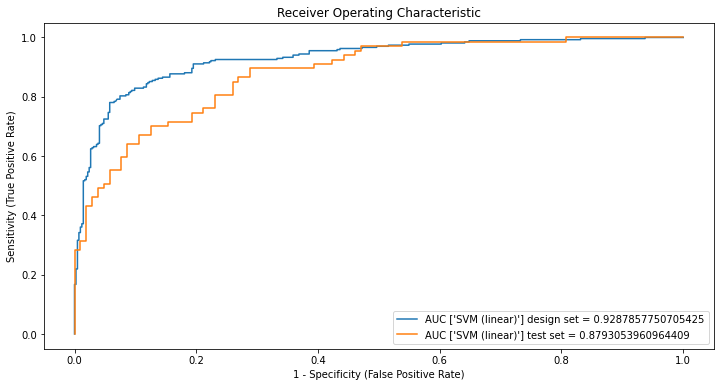

     Classifier  AUC score  Accuracy  Sensitivity  Specificity
0  SVM (linear)   0.879305  0.783626     0.826923     0.716418


In [ ]:
names_clfs = ['SVM (linear)']
# Univariate feature selection  
threshold = 2 
selected_data_univ_designset_norm = data_designset_norm[most_counted_selected_features[threshold]]
selected_data_univ_testset_norm = data_testset_norm[most_counted_selected_features[threshold]]
# Train classifier 
svm = SVC(kernel='linear', C=1000, gamma=1, probability=True, random_state=0)
svm.fit(selected_data_univ_designset_norm, label_designset)   
# Apply classifier on design set
y_pred_d = svm.predict(selected_data_univ_designset_norm) 
y_pred_d_score = svm.predict_proba(selected_data_univ_designset_norm)[:,1] 
score_d = metrics.roc_auc_score(label_designset, y_pred_d_score)
# Calculate performance on design set
classification_report_d = classification_report(label_designset,y_pred_d, output_dict=True)
accuracy_d = classification_report_d['accuracy']
sensitivity_d = classification_report_d['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
specificity_d = classification_report_d['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'
fpr_d, tpr_d, _ = metrics.roc_curve(label_designset,  y_pred_d_score, pos_label='CN')
# Apply classifier on testset (Make prediction, label with class)
y_pred_test = svm.predict(selected_data_univ_testset_norm) 
# Apply classifier on testset (Make prediction, prediction for CN)
y_pred_test_score = svm.predict_proba(selected_data_univ_testset_norm)[:,1] 
score_test = metrics.roc_auc_score(label_testset, y_pred_test_score)
# Calculate performance on test set
classification_report_test = classification_report(label_testset,y_pred_test, output_dict=True)
accuracy_t = classification_report_test['accuracy']
sensitivity_t = classification_report_test['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
specificity_t = classification_report_test['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'
fpr_t, tpr_t, _ = metrics.roc_curve(label_testset,  y_pred_test_score, pos_label='CN')
# Create ROC curves for design and test set
plt.plot(fpr_d,tpr_d,label="AUC "+str(names_clfs)+" design set = "+str(score_d))
plt.plot(fpr_t,tpr_t,label="AUC "+str(names_clfs)+" test set = "+str(score_test))
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc=4)
plt.show()
# Display results in table
auc_table_t = {'Classifier': names_clfs, 'AUC score': score_test, 'Accuracy': accuracy_t, 'Sensitivity': sensitivity_t, 'Specificity': specificity_t}
print(pd.DataFrame(auc_table_t))